In [1]:
# ============================================================================
# CELL 1: Enhanced Setup with Automatic Download
# ============================================================================

import sys
import subprocess
import importlib

def install_packages():
    """Install required packages"""
    packages = [
        'pypdf', 'tqdm', 'pandas', 'numpy', 'matplotlib', 'seaborn', 
        'networkx', 'scikit-learn', 'requests', 'beautifulsoup4'
    ]
    print(" Installing required packages...")
    for pkg in packages:
        try:
            if pkg == 'beautifulsoup4':
                importlib.import_module('bs4')
            else:
                importlib.import_module(pkg if pkg != 'pypdf' else 'pypdf')
            print(f"  ✓ {pkg} already installed")
        except ImportError:
            print(f"  ⟳ Installing {pkg}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
            print(f"  ✓ {pkg} installed")
    print("\n All packages ready!\n")

install_packages()

import os
import re
import json
import hashlib
import time
import logging
from dataclasses import dataclass, field, asdict
from typing import List, Dict, Tuple, Set, Optional
from collections import Counter, defaultdict
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from pypdf import PdfReader
from tqdm import tqdm

# For automatic download
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Suppress pypdf warnings
logging.getLogger("pypdf").setLevel(logging.ERROR)

# Set up matplotlib style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

# Configuration
PDF_DIR = "data/pdfs"
OUT_DIR = "outputs"
CHART_DIR = os.path.join(OUT_DIR, "charts")

os.makedirs(PDF_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(CHART_DIR, exist_ok=True)

print("="*70)
print(" ENHANCED NEURIPS 2024 SAFETY ANALYSIS SYSTEM")
print("="*70)
print(f"\n PDF Directory: {os.path.abspath(PDF_DIR)}")
print(f" Output Directory: {os.path.abspath(OUT_DIR)}")
print(f" Charts Directory: {os.path.abspath(CHART_DIR)}")
print("\n" + "="*70)

 Installing required packages...
  ✓ pypdf already installed
  ✓ tqdm already installed
  ✓ pandas already installed
  ✓ numpy already installed
  ✓ matplotlib already installed
  ✓ seaborn already installed
  ✓ networkx already installed
  ⟳ Installing scikit-learn...
  ✓ scikit-learn installed
  ✓ requests already installed
  ✓ beautifulsoup4 already installed

 All packages ready!

 ENHANCED NEURIPS 2024 SAFETY ANALYSIS SYSTEM

 PDF Directory: C:\Users\aryan\data\pdfs
 Output Directory: C:\Users\aryan\outputs
 Charts Directory: C:\Users\aryan\outputs\charts



In [3]:
# ============================================================================
# CELL 2: Automatic PDF Download + Manual Upload Option
# ============================================================================

def download_neurips_2024_pdfs(pdf_dir: str, max_papers: int = 300):
    """
    Crawl NeurIPS 2024 proceedings and download PDFs.
    """
    index_url = "https://papers.nips.cc/paper_files/paper/2024"
    headers = {
        "User-Agent": "Mozilla/5.0 (compatible; ResearchAnalysis/1.0)"
    }

    print(f" Downloading NeurIPS 2024 PDFs into {pdf_dir}")
    print(f" Target: up to {max_papers} papers")
    
    try:
        resp = requests.get(index_url, headers=headers, timeout=30)
        resp.raise_for_status()
    except Exception as e:
        print(f" Could not fetch NeurIPS 2024 index page: {e}")
        return 0

    soup = BeautifulSoup(resp.text, "html.parser")

    abstract_links = []
    for a in soup.find_all("a", href=True):
        href = a["href"]
        if "/paper_files/paper/2024/hash/" in href and href.endswith("Abstract-Conference.html"):
            abs_url = urljoin(index_url, href)
            if abs_url not in abstract_links:
                abstract_links.append(abs_url)

    if not abstract_links:
        print(" No abstract links found on index page.")
        return 0

    print(f"✓ Found {len(abstract_links)} papers on index page")
    print(f"  Downloading PDFs...\n")
    
    downloaded = 0
    skipped = 0
    failed = 0

    with tqdm(total=min(max_papers, len(abstract_links)), desc="Downloading") as pbar:
        for abs_url in abstract_links:
            if downloaded >= max_papers:
                break

            try:
                r2 = requests.get(abs_url, headers=headers, timeout=30)
                r2.raise_for_status()
            except Exception as e:
                failed += 1
                pbar.update(1)
                continue

            soup2 = BeautifulSoup(r2.text, "html.parser")
            pdf_url = None

            # Find PDF link
            for a in soup2.find_all("a", href=True):
                href = a["href"]
                if href.lower().endswith(".pdf") and "Paper-Conference" in href:
                    pdf_url = urljoin(abs_url, href)
                    break

            if pdf_url is None:
                for a in soup2.find_all("a", href=True):
                    href = a["href"]
                    if href.lower().endswith(".pdf"):
                        pdf_url = urljoin(abs_url, href)
                        break

            if pdf_url is None:
                failed += 1
                pbar.update(1)
                continue

            filename = os.path.basename(pdf_url.split("?")[0])
            out_path = os.path.join(pdf_dir, filename)

            if os.path.exists(out_path):
                skipped += 1
                downloaded += 1
                pbar.update(1)
                continue

            try:
                with requests.get(pdf_url, headers=headers, stream=True, timeout=120) as rpdf:
                    rpdf.raise_for_status()
                    with open(out_path, "wb") as f:
                        for chunk in rpdf.iter_content(chunk_size=8192):
                            if chunk:
                                f.write(chunk)
                downloaded += 1
                pbar.update(1)
                time.sleep(0.5)  # Be nice to the server
            except Exception as e:
                failed += 1
                pbar.update(1)

    print(f"\n Download complete!")
    print(f"   • Downloaded: {downloaded - skipped} new papers")
    print(f"   • Skipped (already exists): {skipped}")
    print(f"   • Failed: {failed}")
    print(f"   • Total papers available: {downloaded}\n")
    
    return downloaded


def manual_upload_widget():
    """
    Jupyter widget for manual PDF upload (if available).
    """
    try:
        from IPython.display import display
        import ipywidgets as widgets
        
        uploader = widgets.FileUpload(
            accept='.pdf',
            multiple=True,
            description='Upload PDFs',
            layout=widgets.Layout(width='300px')
        )
        
        output = widgets.Output()
        
        def on_upload(change):
            with output:
                output.clear_output()
                if uploader.value:
                    print(f" Uploading {len(uploader.value)} files...")
                    for uploaded_file in uploader.value:
                        filename = uploaded_file['name']
                        content = uploaded_file['content']
                        
                        if filename.lower().endswith('.pdf'):
                            path = os.path.join(PDF_DIR, filename)
                            with open(path, 'wb') as f:
                                f.write(content.tobytes())
                            print(f"  ✓ {filename}")
                    print(f"\n Upload complete!")
        
        uploader.observe(on_upload, names='value')
        
        display(widgets.VBox([
            widgets.HTML(value="<h3>📎 Manual Upload (Optional)</h3>"),
            uploader,
            output
        ]))
        
        return True
    except ImportError:
        print("  Manual upload widget not available (not in Jupyter environment)")
        return False


# ============================================================================
# RUN DATA COLLECTION
# ============================================================================

print("="*70)
print(" DATA COLLECTION")
print("="*70)

# Check existing files
existing_pdfs = [f for f in os.listdir(PDF_DIR) if f.lower().endswith('.pdf')]

if existing_pdfs:
    print(f"\n Found {len(existing_pdfs)} existing PDF(s) in {PDF_DIR}")
    print("\nOptions:")
    print("  1. Use existing files")
    print("  2. Download more papers from NeurIPS 2024")
    print("  3. Both (use existing + download more)")
    
    choice = input("\nEnter choice (1/2/3): ").strip()
    
    if choice == "1":
        print(f"\n Using {len(existing_pdfs)} existing files")
        print(" Proceed to Cell 3 for analysis")
    elif choice == "2":
        max_papers = int(input("How many papers to download? (default: 300): ") or "300")
        downloaded = download_neurips_2024_pdfs(PDF_DIR, max_papers)
    else:  # choice == "3"
        max_papers = int(input("How many additional papers to download? (default: 100): ") or "100")
        downloaded = download_neurips_2024_pdfs(PDF_DIR, max_papers)
else:
    print("\n No existing PDFs found")
    print("\nOptions:")
    print("  1. Download from NeurIPS 2024 automatically")
    print("  2. Upload PDFs manually")
    
    choice = input("\nEnter choice (1/2): ").strip()
    
    if choice == "1":
        max_papers = int(input("How many papers to download? (default: 300): ") or "300")
        downloaded = download_neurips_2024_pdfs(PDF_DIR, max_papers)
    else:
        print("\n Manual upload mode:")
        manual_upload_widget()

# Final count
final_pdfs = [f for f in os.listdir(PDF_DIR) if f.lower().endswith('.pdf')]
print(f"\n{'='*70}")
print(f" TOTAL PAPERS AVAILABLE: {len(final_pdfs)}")
print(f"{'='*70}")

if len(final_pdfs) == 0:
    print("\n  WARNING: No PDFs available for analysis!")
    print("Please run this cell again and choose a data collection method.")

 DATA COLLECTION

 Found 1033 existing PDF(s) in data/pdfs

Options:
  1. Use existing files
  2. Download more papers from NeurIPS 2024
  3. Both (use existing + download more)



Enter choice (1/2/3):  1



 Using 1033 existing files
 Proceed to Cell 3 for analysis

 TOTAL PAPERS AVAILABLE: 1033


In [4]:
# ============================================================================
# CELL 3: NeurIPS Checklist Questions + Enhanced Safety Taxonomy
# ============================================================================

# ============================================================================
# NeurIPS 2024 STANDARDIZED CHECKLIST (15 Questions)
# ============================================================================

NEURIPS_QUESTIONS = {
    1: {
        "text": "Do the main claims made in the abstract and introduction accurately reflect the paper's contributions and scope?",
        "keywords": ["claims", "abstract", "introduction", "contributions", "scope", "accurately reflect"],
        "category": "research_integrity"
    },
    2: {
        "text": "Does the paper discuss the limitations of the work performed by the authors?",
        "keywords": ["limitations", "limitation", "drawback", "weakness", "constraint", "scope", "boundary"],
        "category": "transparency"
    },
    3: {
        "text": "For each theoretical result, does the paper provide the full set of assumptions and a complete (and correct) proof?",
        "keywords": ["theoretical", "theorem", "proof", "assumptions", "lemma", "proposition"],
        "category": "research_integrity"
    },
    4: {
        "text": "Does the paper fully disclose all the information needed to reproduce the main results?",
        "keywords": ["reproduce", "reproducibility", "replication", "details", "code", "hyperparameters", "data"],
        "category": "reproducibility"
    },
    5: {
        "text": "Does the research conducted in the paper conform to ethical guidelines?",
        "keywords": ["ethics", "ethical", "irb", "ethics board", "ethics committee", "guidelines", "approval"],
        "category": "ethics"
    },
    6: {
        "text": "Does the paper describe safeguards that have been put in place for responsible release of data or models?",
        "keywords": ["safeguards", "responsible release", "release protocol", "safety measures", "access control"],
        "category": "deployment_safety"
    },
    7: {
        "text": "Are the creators or original owners of assets (e.g., code, data, models) credited?",
        "keywords": ["credit", "attribution", "cite", "acknowledge", "asset", "owner", "creator"],
        "category": "attribution"
    },
    8: {
        "text": "Does the paper discuss whether and how consent was obtained from people whose data you're using/curating?",
        "keywords": ["consent", "informed consent", "permission", "opt-in", "opt-out", "data subjects"],
        "category": "data_ethics"
    },
    9: {
        "text": "Has an analysis of the potential impact of the dataset and its use on data subjects been conducted?",
        "keywords": ["impact", "data subjects", "privacy", "harm", "affected", "consequences"],
        "category": "impact_assessment"
    },
    10: {
        "text": "Does the paper describe potential risks incurred by study participants?",
        "keywords": ["risks", "participants", "subjects", "harm", "danger", "adverse"],
        "category": "participant_safety"
    },
    11: {
        "text": "Are there processes in place to address these risks to participants?",
        "keywords": ["process", "address risks", "mitigation", "safeguard", "protection", "risk management"],
        "category": "risk_mitigation"
    },
    12: {
        "text": "Does the paper document how workers were compensated?",
        "keywords": ["compensation", "payment", "wage", "workers", "annotators", "crowdwork"],
        "category": "labor_ethics"
    },
    13: {
        "text": "Does the paper discuss potential misuse of the work?",
        "keywords": ["misuse", "abuse", "dual-use", "malicious", "harmful application", "weaponization"],
        "category": "misuse_prevention"
    },
    14: {
        "text": "Could the paper have been published without releasing code or data?",
        "keywords": ["code release", "data release", "open source", "availability"],
        "category": "openness"
    },
    15: {
        "text": "Does the paper specify all the training details (e.g., data splits, hyperparameters, how they were chosen)?",
        "keywords": ["training details", "hyperparameters", "data splits", "architecture", "optimization"],
        "category": "reproducibility"
    }
}

# ============================================================================
# ENHANCED SAFETY TAXONOMY (17 Categories - for your Level 1 mapping)
# ============================================================================

SAFETY_TAXONOMY = {
    # ===== DATA SAFETY =====
    "data_privacy_leakage": {
        "keywords": [
            "privacy leak", "data leak", "information leak", "privacy breach",
            "personally identifiable", "pii", "sensitive information",
            "re-identification", "de-anonymization", "linkage attack",
            "membership inference", "attribute inference",
            "gdpr", "hipaa", "ccpa", "ferpa", "data protection",
        ],
        "maps_to_questions": [8, 9],  # NEW: Maps to NeurIPS questions
        "severity_weight": 3
    },
    
    "data_consent_ethics": {
        "keywords": [
            "informed consent", "consent form", "irb approval", "ethics board",
            "ethics committee", "ethics review", "human subjects",
            "participant consent", "opt-in", "opt-out",
            "data subject rights", "right to deletion",
        ],
        "maps_to_questions": [5, 8],
        "severity_weight": 3
    },
    
    "data_quality_integrity": {
        "keywords": [
            "data poisoning", "poisoning attack", "backdoor data",
            "label manipulation", "corrupted data", "malicious data",
            "noisy labels", "mislabeled", "annotation error",
            "data contamination", "data leakage", "train-test leakage",
            "dataset artifact", "spurious correlation",
        ],
        "maps_to_questions": [4, 9],
        "severity_weight": 2
    },
    
    "data_bias_representation": {
        "keywords": [
            "dataset bias", "sampling bias", "selection bias",
            "underrepresented", "overrepresented", "demographic imbalance",
            "geographic bias", "temporal bias", "historical bias",
            "representation gap", "coverage gap",
        ],
        "maps_to_questions": [9],
        "severity_weight": 2
    },
    
    # ===== MODEL SAFETY =====
    "model_robustness": {
        "keywords": [
            "adversarial attack", "adversarial example", "adversarial robustness",
            "evasion attack", "perturbation", "adversarial training",
            "out-of-distribution", "ood", "distribution shift",
            "domain shift", "covariate shift", "concept drift",
            "corner case", "edge case", "stress test", "failure mode",
        ],
        "maps_to_questions": [2, 13],
        "severity_weight": 2
    },
    
    "model_interpretability": {
        "keywords": [
            "explainability", "interpretability", "transparency",
            "black box", "opaque model", "lack of explanation",
            "feature importance", "attribution", "saliency",
            "attention visualization", "model understanding",
        ],
        "maps_to_questions": [2],
        "severity_weight": 1
    },
    
    "model_security": {
        "keywords": [
            "model extraction", "model stealing", "model theft",
            "backdoor attack", "trojan", "neural trojan",
            "trigger-based attack", "poisoned model",
            "membership inference", "training data extraction",
            "model inversion",
        ],
        "maps_to_questions": [6, 13],
        "severity_weight": 3
    },
    
    "model_reliability": {
        "keywords": [
            "uncertainty quantification", "confidence calibration",
            "overconfident prediction", "miscalibration",
            "silent failure", "graceful degradation",
            "fail-safe", "error handling", "fallback mechanism",
            "monitoring system", "anomaly detection",
        ],
        "maps_to_questions": [2, 6],
        "severity_weight": 2
    },
    
    # ===== DEPLOYMENT SAFETY =====
    "misuse_potential": {
        "keywords": [
            "dual-use", "misuse", "abuse potential", "malicious use",
            "harmful application", "weaponization",
            "surveillance", "facial recognition misuse",
            "deepfake", "synthetic media", "disinformation",
            "automated harassment", "manipulation",
            "misuse prevention", "access control", "usage policy",
        ],
        "maps_to_questions": [13],
        "severity_weight": 3
    },
    
    "real_world_harm": {
        "keywords": [
            "physical safety", "bodily harm", "injury risk",
            "safety-critical", "medical risk", "patient safety",
            "psychological harm", "mental health risk", "emotional harm",
            "harmful content", "disturbing content",
            "discrimination", "disparate impact", "harm to group",
            "marginalized community", "vulnerable population",
        ],
        "maps_to_questions": [9, 10, 13],
        "severity_weight": 3
    },
    
    "deployment_readiness": {
        "keywords": [
            "production deployment", "real-world deployment",
            "deployment risk", "rollout strategy", "staged rollout",
            "rollback plan", "kill switch", "emergency stop",
            "incident response", "safety monitoring",
            "human-in-the-loop", "human oversight",
        ],
        "maps_to_questions": [6, 11],
        "severity_weight": 2
    },
    
    # ===== FAIRNESS & BIAS =====
    "fairness_violations": {
        "keywords": [
            "unfair", "discriminatory", "discrimination",
            "protected attribute", "protected class",
            "demographic parity", "equalized odds", "equal opportunity",
            "disparate treatment", "disparate impact",
            "fairness metric", "bias metric",
        ],
        "maps_to_questions": [9],
        "severity_weight": 3
    },
    
    "bias_amplification": {
        "keywords": [
            "bias amplification", "reinforce bias", "perpetuate bias",
            "stereotyping", "stereotype", "harmful association",
            "social bias", "cultural bias", "gender bias", "racial bias",
        ],
        "maps_to_questions": [9],
        "severity_weight": 3
    },
    
    # ===== REPRODUCIBILITY =====
    "reproducibility_concerns": {
        "keywords": [
            "not reproducible", "cannot reproduce", "reproduction failure",
            "missing details", "insufficient documentation",
            "closed source", "proprietary", "no code available",
            "no data available", "cannot verify",
            "random seed not set", "non-deterministic",
        ],
        "maps_to_questions": [4, 14, 15],
        "severity_weight": 1
    },
    
    "evaluation_validity": {
        "keywords": [
            "evaluation flaw", "metric gaming", "goodhart",
            "benchmark overfitting", "data contamination",
            "cherry-picking", "selective reporting",
            "misleading metric", "inappropriate baseline",
            "inadequate testing", "no red team",
        ],
        "maps_to_questions": [1, 3],
        "severity_weight": 2
    },
    
    # ===== ENVIRONMENTAL =====
    "environmental_impact": {
        "keywords": [
            "carbon footprint", "carbon emission", "co2 emission",
            "energy consumption", "computational cost",
            "environmental impact", "sustainability",
            "green ai", "energy efficiency",
        ],
        "maps_to_questions": [2],
        "severity_weight": 1
    },
    
    "resource_accessibility": {
        "keywords": [
            "compute requirements", "resource intensive",
            "inaccessible", "barrier to entry",
            "concentration of power", "compute inequality",
            "academic accessibility",
        ],
        "maps_to_questions": [2],
        "severity_weight": 1
    },
}

# ============================================================================
# USE CASE DOMAINS 
# ============================================================================

USE_CASE_DOMAINS = {
    "healthcare": {
        "keywords": ["medical", "clinical", "patient", "diagnosis", "treatment", "hospital", "health", 
                    "disease", "pharmaceutical", "therapeutic", "healthcare"],
        "risk_level": "critical"
    },
    "finance": {
        "keywords": ["financial", "trading", "investment", "banking", "fraud detection", "credit",
                    "loan", "insurance", "risk assessment", "market"],
        "risk_level": "high"
    },
    "autonomous_systems": {
        "keywords": ["autonomous", "self-driving", "robotics", "navigation", "drone", "vehicle",
                    "autopilot", "robot", "automated driving"],
        "risk_level": "critical"
    },
    "content_moderation": {
        "keywords": ["moderation", "content filtering", "harmful content", "toxic", "hate speech",
                    "misinformation", "moderation"],
        "risk_level": "high"
    },
    "surveillance": {
        "keywords": ["surveillance", "monitoring", "facial recognition", "tracking", "identification",
                    "biometric", "watch"],
        "risk_level": "critical"
    },
    "education": {
        "keywords": ["educational", "student", "learning", "tutoring", "assessment", "teaching",
                    "classroom", "academic"],
        "risk_level": "medium"
    },
    "legal": {
        "keywords": ["legal", "law", "court", "justice", "judicial", "attorney", "litigation"],
        "risk_level": "critical"
    },
    "scientific_research": {
        "keywords": ["scientific", "research", "discovery", "experiment", "laboratory", "analysis"],
        "risk_level": "medium"
    },
    "creative_tools": {
        "keywords": ["creative", "generation", "artistic", "design", "synthesis", "art", "music"],
        "risk_level": "low"
    },
    "social_media": {
        "keywords": ["social media", "recommendation", "feed", "engagement", "viral", "platform"],
        "risk_level": "high"
    }
}

# ============================================================================
# ADDITIONAL DETECTION PATTERNS
# ============================================================================

# Author voice patterns 
AUTHOR_CONCERN_PATTERNS = [
    r"(we|our|this work|this paper|this model|this approach) (acknowledge|recognize|note|caution|warn|identify).{0,30}(risk|concern|limitation|harm|issue|problem)",
    r"(could|may|might|can) (lead to|result in|cause).{0,30}(harm|misuse|bias|failure|error|problem)",
    r"(potential|possible) (for|risk of).{0,30}(abuse|misuse|harm|discrimination|bias|failure)",
    r"(not suitable|inappropriate|not recommended) for.{0,30}(safety-critical|high-stakes|sensitive)",
    r"(should not|must not|cannot|do not) (be )?(used|deployed|applied).{0,30}(without|unless)",
    r"(important|critical|essential|necessary) to (consider|address|mitigate|prevent).{0,30}(risk|harm|misuse|bias)",
]

# Severity indicators
SEVERITY_KEYWORDS = {
    "critical": [
        "critical", "severe", "serious", "significant concern",
        "major risk", "high risk", "dangerous", "harmful",
        "life-threatening", "safety-critical", "catastrophic",
    ],
    "moderate": [
        "moderate", "potential risk", "possible harm",
        "concerning", "notable", "considerable",
    ],
    "low": [
        "minor", "low risk", "limited", "minimal",
        "negligible", "acceptable risk",
    ],
}

# Mitigation indicators
MITIGATION_KEYWORDS = [
    "mitigate", "mitigation", "safeguard", "protection",
    "address", "remediate", "fix", "prevent",
    "monitor", "detect", "filter", "validate",
    "red team", "adversarial training", "safety training",
    "alignment", "rlhf", "safety measure",
]

# Research areas (for categorization)
RESEARCH_AREAS = {
    "computer_vision": [
        "image", "visual", "video", "object detection", "segmentation",
        "cnn", "convolutional", "resnet", "vision transformer",
        "recognition", "face", "scene",
    ],
    "natural_language_processing": [
        "language", "text", "nlp", "bert", "gpt", "transformer", "llm",
        "translation", "sentiment", "question answering",
        "summarization", "named entity", "tokeniz",
    ],
    "reinforcement_learning": [
        "reinforcement", "rl", "agent", "policy", "reward",
        "q-learning", "actor-critic", "dqn", "ppo",
        "environment", "markov decision",
    ],
    "generative_models": [
        "generative", "gan", "diffusion", "vae", "autoencoder",
        "generate", "synthesis", "sampling",
    ],
    "theory": [
        "theorem", "proof", "convergence", "complexity",
        "theoretical", "bound", "guarantee",
    ],
}

print(" Configuration loaded!")
print(f"   • {len(NEURIPS_QUESTIONS)} NeurIPS checklist questions defined")
print(f"   • {len(SAFETY_TAXONOMY)} safety categories in taxonomy")
print(f"   • {len(USE_CASE_DOMAINS)} use case domains")
print(f"   • {len(AUTHOR_CONCERN_PATTERNS)} author concern patterns")

 Configuration loaded!
   • 15 NeurIPS checklist questions defined
   • 17 safety categories in taxonomy
   • 10 use case domains
   • 6 author concern patterns


In [5]:
# ============================================================================
# 3.5: LITERATURE MAPPING - Grounding Safety Categories in Frameworks
# ============================================================================


import pandas as pd
from IPython.display import display, HTML

# Literature mapping: Connect each safety category to established frameworks
LITERATURE_MAPPING = {
    "data_privacy_leakage": {
        "frameworks": [
            "EU AI Act Article 10 (Data Governance)",
            "NIST AI RMF - Privacy Domain",
            "IEEE P7000 (Model Process for Addressing Ethical Concerns)",
            "ISO/IEC 27701 (Privacy Information Management)"
        ],
        "key_papers": [
            "Carlini et al. 2021 - Extracting Training Data from LLMs",
            "Shokri et al. 2017 - Membership Inference Attacks"
        ]
    },
    "data_consent_ethics": {
        "frameworks": [
            "EU GDPR Article 6-7 (Lawfulness of processing, Consent)",
            "Belmont Report (Respect for Persons)",
            "IEEE Ethically Aligned Design - Principle 1 (Human Rights)",
            "Partnership on AI - Data Transparency Guidelines"
        ],
        "key_papers": [
            "Gebru et al. 2021 - Datasheets for Datasets",
            "Hutchinson et al. 2021 - Towards Accountability"
        ]
    },
    "data_quality_integrity": {
        "frameworks": [
            "NIST AI RMF - Data Integrity",
            "ISO/IEC 25012 (Data Quality Model)",
            "Partnership on AI - Data Incident Database"
        ],
        "key_papers": [
            "Gu et al. 2019 - BadNets (Backdoor Attacks)",
            "Chen et al. 2017 - Targeted Backdoor Attacks"
        ]
    },
    "data_bias_representation": {
        "frameworks": [
            "EU AI Act Article 10 (Data governance for high-risk systems)",
            "IEEE P7003 (Algorithmic Bias Considerations)",
            "Partnership on AI - Fairness Guidelines",
            "Montreal Declaration - Principle of Well-being"
        ],
        "key_papers": [
            "Buolamwini & Gebru 2018 - Gender Shades",
            "Mehrabi et al. 2021 - Survey on Bias and Fairness"
        ]
    },
    "model_robustness": {
        "frameworks": [
            "NIST AI RMF - Robustness Domain",
            "ISO/IEC 24029-1 (Assessment of neural network robustness)",
            "EU AI Act Article 15 (Accuracy requirements)"
        ],
        "key_papers": [
            "Goodfellow et al. 2015 - Explaining and Harnessing Adversarial Examples",
            "Madry et al. 2018 - Towards Deep Learning Models Resistant to Adversarial Attacks"
        ]
    },
    "fairness_discrimination": {
        "frameworks": [
            "EU AI Act Article 9 (Risk management for discrimination)",
            "IEEE P7003 (Algorithmic Bias)",
            "ACM Code of Ethics - Principle 1.4 (Be fair and non-discriminatory)",
            "Montreal Declaration - Principle of Justice"
        ],
        "key_papers": [
            "Barocas & Selbst 2016 - Big Data's Disparate Impact",
            "Hardt et al. 2016 - Equality of Opportunity"
        ]
    },
    "interpretability_transparency": {
        "frameworks": [
            "EU AI Act Article 13 (Transparency for high-risk systems)",
            "NIST AI RMF - Transparency Domain",
            "IEEE P7001 (Transparency of Autonomous Systems)",
            "GDPR Article 22 (Right to explanation)"
        ],
        "key_papers": [
            "Lipton 2018 - The Mythos of Model Interpretability",
            "Ribeiro et al. 2016 - LIME"
        ]
    },
    "model_security": {
        "frameworks": [
            "NIST Cybersecurity Framework",
            "ISO/IEC 27001 (Information Security)",
            "Partnership on AI - AI Security Best Practices"
        ],
        "key_papers": [
            "Papernot et al. 2016 - Practical Black-Box Attacks",
            "Tramèr et al. 2016 - Stealing Machine Learning Models"
        ]
    },
    "misuse_dual_use": {
        "frameworks": [
            "EU AI Act - Prohibited Practices (Article 5)",
            "Montreal Declaration - Principle of Responsibility",
            "Partnership on AI - Responsible AI Practices",
            "IEEE Ethically Aligned Design - Principle 5 (Misuse)"
        ],
        "key_papers": [
            "Brundage et al. 2018 - The Malicious Use of AI",
            "Solaiman et al. 2019 - GPT-2 Release Strategy"
        ]
    },
    "deployment_safety": {
        "frameworks": [
            "EU AI Act Article 6 (Classification of high-risk systems)",
            "NIST AI RMF - Deployment Considerations",
            "ISO/IEC 23894 (AI Risk Management)"
        ],
        "key_papers": [
            "Amodei et al. 2016 - Concrete Problems in AI Safety",
            "Sculley et al. 2015 - Hidden Technical Debt in ML Systems"
        ]
    },
    "human_oversight": {
        "frameworks": [
            "EU AI Act Article 14 (Human oversight)",
            "IEEE Ethically Aligned Design - Principle 2 (Accountability)",
            "Montreal Declaration - Principle of Democratic Participation"
        ],
        "key_papers": [
            "Green & Chen 2019 - Disparate Interactions",
            "Bansal et al. 2021 - Does the Whole Exceed its Parts"
        ]
    },
    "economic_social_impact": {
        "frameworks": [
            "Montreal Declaration - Principle of Solidarity",
            "IEEE Ethically Aligned Design - Economic Impact Assessment",
            "OECD AI Principles - Inclusive growth"
        ],
        "key_papers": [
            "Acemoglu & Restrepo 2020 - Robots and Jobs",
            "Korinek & Stiglitz 2021 - AI and Inequality"
        ]
    },
    "security_vulnerabilities": {
        "frameworks": [
            "NIST Cybersecurity Framework",
            "ISO/IEC 27034 (Application Security)",
            "MITRE ATT&CK for Machine Learning"
        ],
        "key_papers": [
            "Nicolae et al. 2019 - Adversarial Robustness Toolbox",
            "Kurakin et al. 2017 - Adversarial ML at Scale"
        ]
    },
    "verification_testing": {
        "frameworks": [
            "ISO/IEC 29119 (Software Testing)",
            "NIST AI RMF - Validation and Verification",
            "IEEE P2089 (Age-Appropriate AI)"
        ],
        "key_papers": [
            "Katz et al. 2017 - Reluplex: Verifying Deep RL Networks",
            "Huang et al. 2020 - A Survey of Safety in ML"
        ]
    },
    "evaluation_validity": {
        "frameworks": [
            "ACM Code of Ethics - Principle 1.3 (Be honest and trustworthy)",
            "AAAI/ACM Conference on AI, Ethics, and Society",
            "IEEE P2863 (Organizational Governance of AI)"
        ],
        "key_papers": [
            "Lipton & Steinhardt 2019 - Troubling Trends in ML",
            "Bender & Friedman 2018 - Data Statements"
        ]
    },
    "environmental_impact": {
        "frameworks": [
            "Montreal Declaration - Principle of Sustainability",
            "OECD AI Principles - Sustainable Development",
            "EU Green Deal - Digital Sustainability"
        ],
        "key_papers": [
            "Strubell et al. 2019 - Energy and Policy Considerations",
            "Schwartz et al. 2020 - Green AI"
        ]
    },
    "resource_accessibility": {
        "frameworks": [
            "Montreal Declaration - Principle of Justice",
            "OECD AI Principles - Inclusive growth",
            "UNESCO Recommendation on Ethics of AI"
        ],
        "key_papers": [
            "Hooker 2021 - The Hardware Lottery",
            "Birhane et al. 2022 - The Forgotten Margins"
        ]
    }
}

def display_literature_mapping():
    """
    Display literature mapping as a formatted table for inclusion in paper
    """
    
    print("="*80)
    print(" LITERATURE MAPPING: Grounding Safety Taxonomy in Established Frameworks")
    print("="*80)
    print("\nOur 17 safety categories are derived from and aligned with established")
    print("AI governance frameworks, standards, and academic literature:\n")
    
    # Create DataFrame for display
    mapping_data = []
    for category, info in LITERATURE_MAPPING.items():
        frameworks_str = "; ".join(info["frameworks"][:2])  # Show first 2
        papers_str = info["key_papers"][0] if info["key_papers"] else "N/A"
        
        mapping_data.append({
            "Safety Category": category.replace("_", " ").title(),
            "Primary Frameworks": frameworks_str,
            "Example Citation": papers_str
        })
    
    df = pd.DataFrame(mapping_data)
    
    # Display as HTML table
    display(HTML(df.to_html(index=False, escape=False, 
                            classes='dataframe',
                            justify='left')))
    
    print("\n" + "="*80)
    print(" All categories grounded in peer-reviewed literature and standards")
    print("="*80)
    
    # Save to CSV for paper
    df_full = []
    for category, info in LITERATURE_MAPPING.items():
        df_full.append({
            "category": category,
            "frameworks": ", ".join(info["frameworks"]),
            "key_papers": ", ".join(info["key_papers"])
        })
    
    lit_df = pd.DataFrame(df_full)
    lit_df.to_csv(os.path.join(OUT_DIR, "literature_mapping.csv"), index=False)
    print(f"\n Detailed mapping saved to: {OUT_DIR}/literature_mapping.csv")
    
    return lit_df

# Run the mapping display
literature_df = display_literature_mapping()

 LITERATURE MAPPING: Grounding Safety Taxonomy in Established Frameworks

Our 17 safety categories are derived from and aligned with established
AI governance frameworks, standards, and academic literature:



Safety Category,Primary Frameworks,Example Citation
Data Privacy Leakage,EU AI Act Article 10 (Data Governance); NIST AI RMF - Privacy Domain,Carlini et al. 2021 - Extracting Training Data from LLMs
Data Consent Ethics,"EU GDPR Article 6-7 (Lawfulness of processing, Consent); Belmont Report (Respect for Persons)",Gebru et al. 2021 - Datasheets for Datasets
Data Quality Integrity,NIST AI RMF - Data Integrity; ISO/IEC 25012 (Data Quality Model),Gu et al. 2019 - BadNets (Backdoor Attacks)
Data Bias Representation,EU AI Act Article 10 (Data governance for high-risk systems); IEEE P7003 (Algorithmic Bias Considerations),Buolamwini & Gebru 2018 - Gender Shades
Model Robustness,NIST AI RMF - Robustness Domain; ISO/IEC 24029-1 (Assessment of neural network robustness),Goodfellow et al. 2015 - Explaining and Harnessing Adversarial Examples
Fairness Discrimination,EU AI Act Article 9 (Risk management for discrimination); IEEE P7003 (Algorithmic Bias),Barocas & Selbst 2016 - Big Data's Disparate Impact
Interpretability Transparency,EU AI Act Article 13 (Transparency for high-risk systems); NIST AI RMF - Transparency Domain,Lipton 2018 - The Mythos of Model Interpretability
Model Security,NIST Cybersecurity Framework; ISO/IEC 27001 (Information Security),Papernot et al. 2016 - Practical Black-Box Attacks
Misuse Dual Use,EU AI Act - Prohibited Practices (Article 5); Montreal Declaration - Principle of Responsibility,Brundage et al. 2018 - The Malicious Use of AI
Deployment Safety,EU AI Act Article 6 (Classification of high-risk systems); NIST AI RMF - Deployment Considerations,Amodei et al. 2016 - Concrete Problems in AI Safety



 All categories grounded in peer-reviewed literature and standards

 Detailed mapping saved to: outputs/literature_mapping.csv


##  Safety Taxonomy Development

Our analysis framework employs 17 safety categories derived from established AI governance 
frameworks and peer-reviewed literature. Rather than developing an independent taxonomy, 
we systematically aligned our categories with recognized standards including:

• EU AI Act (2024) - Risk categories and high-risk system definitions
• NIST AI Risk Management Framework (2023) - Core safety domains
• IEEE Ethically Aligned Design (2019) - Ethical principles for AI systems  
• Partnership on AI Guidelines - Data transparency and safety practices
• Montreal Declaration for Responsible AI (2018) - Foundational principles

Each of our 17 categories maps to one or more of these frameworks, ensuring our 
analysis is grounded in current regulatory and ethical standards rather than ad hoc 
definitions. For example:

• "Data Privacy Leakage" aligns with EU AI Act Article 10 (Data Governance), 
  NIST RMF Privacy Domain, and draws from academic work on membership inference 
  attacks (Shokri et al. 2017)

• "Fairness & Discrimination" maps to EU AI Act Article 9, IEEE P7003 (Algorithmic 
  Bias), and builds on foundational fairness research (Barocas & Selbst 2016; 
  Hardt et al. 2016)


# Keyword-Based Detection Approach

Given the scale of our analysis (N=1,033 papers), we employed a keyword-based detection 
approach for initial safety concern identification. For each safety category, we developed 
keyword sets (10-20 terms per category) based on terminology commonly used in AI safety 
literature and regulatory documents.

Keyword development process:
1. Extracted terminology from framework documents (EU AI Act, NIST RMF, etc.)
2. Identified common phrases from relevant academic papers in each domain
3. Included both technical terms (e.g., "membership inference", "adversarial attack") 
   and policy language (e.g., "consent", "transparency", "oversight")

This approach prioritizes RECALL over PRECISION - it is designed to flag papers 
warranting closer examination rather than provide definitive classification. We view 
keyword detection as appropriate for exploratory large-scale screening to identify 
systemic patterns rather than as a gold-standard classification method.


# Two-Level Analysis Framework

Our analysis employs a two-level framework:

Level 1 - Mapping to Checklist Questions:
We systematically mapped each safety category to specific NeurIPS checklist questions 
based on semantic alignment. For example, "data_privacy_leakage" maps to Questions 8 
(consent) and 9 (impact on data subjects). This allows us to determine whether detected 
concerns are addressed by the checklist structure.

Level 2 - Identifying Unmapped Concerns:  
Safety concerns that do not map to any checklist question are flagged as "unmapped gaps" - 
representing potential blind spots in the current review framework. Examples include 
surveillance applications and certain dual-use risks.

In [9]:
# ============================================================================
# CELL 4: Core Text Extraction & Detection Functions
# ============================================================================

import logging
logging.getLogger("pypdf").setLevel(logging.ERROR)

# ============================================================================
# TEXT EXTRACTION
# ============================================================================

def extract_pdf_text(path: str) -> str:
    """Extract full text from PDF."""
    try:
        reader = PdfReader(path)
        pages = [p.extract_text() or "" for p in reader.pages]
        return "\n".join(pages)
    except Exception as e:
        print(f"⚠️  Error extracting text from {path}: {e}")
        return ""


def find_checklist_section(full_text: str, max_chars: int = 25000) -> str:
    """
    Extract the checklist/ethics section from paper.
    Uses multiple anchor patterns for robustness.
    """
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', full_text)
    text_lower = text.lower()
    
    # Try multiple anchor patterns
    anchor_patterns = [
        r'\bneurips\s+paper\s+checklist\b',
        r'\bpaper\s+checklist\b',
        r'\bchecklist\b',
        r'\bethics\s+statement\b',
        r'\bbroader\s+impact\b',
    ]
    
    positions = []
    for pattern in anchor_patterns:
        matches = re.finditer(pattern, text_lower)
        for match in matches:
            positions.append(match.start())
    
    if not positions:
        return ""
    
    # Use earliest match
    start = min(positions)
    return text[start:start + max_chars]


def split_into_sentences(text: str) -> List[str]:
    """
    Split text into sentences.
    Preserves question marks for question detection.
    """
    text = text.replace("\n", " ")
    # Split on . ! but keep ? for question detection
    parts = re.split(r'[.!•●▪\u2022]', text)
    sentences = []
    for p in parts:
        p = p.strip()
        if len(p) > 20:  # Filter very short fragments
            sentences.append(p)
    return sentences


def get_sentence_context(text: str, sentence: str, n_before: int = 1, n_after: int = 1) -> str:
    """
    Get surrounding context for a sentence.
    Useful for extracting evidence snippets.
    """
    sentences = split_into_sentences(text)
    try:
        idx = sentences.index(sentence)
        start = max(0, idx - n_before)
        end = min(len(sentences), idx + n_after + 1)
        return " ".join(sentences[start:end])
    except ValueError:
        return sentence


# ============================================================================
# NEURIPS QUESTION DETECTION
# ============================================================================

def detect_question_response(checklist_text: str, question_id: int) -> Dict:
    """
    Detect if a specific NeurIPS question is addressed in checklist.
    
    Returns:
        {
            'addressed': bool,
            'snippets': List[str],
            'has_safety_concern': bool,
            'concern_details': Optional[Dict]
        }
    """
    question_info = NEURIPS_QUESTIONS[question_id]
    keywords = question_info["keywords"]
    
    # Find sentences containing question keywords
    sentences = split_into_sentences(checklist_text)
    relevant_sentences = []
    
    text_lower = checklist_text.lower()
    
    # Check if any keywords appear
    keyword_found = any(kw.lower() in text_lower for kw in keywords)
    
    if keyword_found:
        # Extract relevant sentences
        for sent in sentences:
            sent_lower = sent.lower()
            if any(kw.lower() in sent_lower for kw in keywords):
                relevant_sentences.append(sent)
    
    if not relevant_sentences:
        return {
            'addressed': False,
            'snippets': [],
            'has_safety_concern': False,
            'concern_details': None
        }
    
    # Check for safety concerns in responses
    has_concern = False
    concern_type = None
    concern_severity = None
    
    for sent in relevant_sentences:
        # Check against safety taxonomy
        for cat_name, cat_info in SAFETY_TAXONOMY.items():
            if any(kw.lower() in sent.lower() for kw in cat_info["keywords"]):
                has_concern = True
                concern_type = cat_name
                
                # Assess severity
                sent_lower = sent.lower()
                if any(kw in sent_lower for kw in SEVERITY_KEYWORDS["critical"]):
                    concern_severity = "critical"
                elif any(kw in sent_lower for kw in SEVERITY_KEYWORDS["moderate"]):
                    concern_severity = "moderate"
                else:
                    concern_severity = "low"
                break
        
        if has_concern:
            break
    
    concern_details = None
    if has_concern:
        concern_details = {
            'type': concern_type,
            'severity': concern_severity,
            'example_snippet': relevant_sentences[0][:200]
        }
    
    return {
        'addressed': True,
        'snippets': relevant_sentences,
        'has_safety_concern': has_concern,
        'concern_details': concern_details
    }


# ============================================================================
# SAFETY TAXONOMY DETECTION
# ============================================================================

def detect_safety_categories(text: str) -> Dict[str, Dict]:
    """
    Detect which safety categories are present in text.
    Returns detailed information for each detected category.
    """
    results = {}
    text_lower = text.lower()
    
    for category_name, category_info in SAFETY_TAXONOMY.items():
        keywords = category_info["keywords"]
        matched_keywords = []
        snippets = []
        
        # Find matching keywords
        for keyword in keywords:
            if keyword.lower() in text_lower:
                matched_keywords.append(keyword)
        
        if matched_keywords:
            # Extract example snippets
            sentences = split_into_sentences(text)
            for sent in sentences:
                if any(kw.lower() in sent.lower() for kw in matched_keywords):
                    snippets.append(sent[:200])
                    if len(snippets) >= 2:  # Max 2 examples per category
                        break
            
            results[category_name] = {
                'detected': True,
                'matched_keywords': matched_keywords[:5],  # Top 5
                'snippets': snippets,
                'severity_weight': category_info["severity_weight"],
                'maps_to_questions': category_info["maps_to_questions"]
            }
        else:
            results[category_name] = {
                'detected': False,
                'matched_keywords': [],
                'snippets': [],
                'severity_weight': category_info["severity_weight"],
                'maps_to_questions': category_info["maps_to_questions"]
            }
    
    return results


# ============================================================================
# USE CASE DETECTION
# ============================================================================

def detect_use_cases(full_text: str) -> List[Dict]:
    """
    Detect mentioned use cases/application domains in paper.
    Searches entire paper, not just checklist.
    """
    use_cases = []
    text_lower = full_text.lower()
    sentences = split_into_sentences(full_text)
    
    for domain_name, domain_info in USE_CASE_DOMAINS.items():
        keywords = domain_info["keywords"]
        
        # Find sentences mentioning this domain
        domain_sentences = []
        for sent in sentences:
            sent_lower = sent.lower()
            if any(kw in sent_lower for kw in keywords):
                domain_sentences.append(sent)
        
        if domain_sentences:
            # Check if safety concerns are mentioned with use case
            has_concern = False
            concern_types = []
            
            for sent in domain_sentences[:3]:  # Check first 3 mentions
                for cat_name, cat_info in SAFETY_TAXONOMY.items():
                    if any(kw.lower() in sent.lower() for kw in cat_info["keywords"]):
                        has_concern = True
                        if cat_name not in concern_types:
                            concern_types.append(cat_name)
            
            use_cases.append({
                'domain': domain_name,
                'risk_level': domain_info['risk_level'],
                'mention_count': len(domain_sentences),
                'has_safety_concern': has_concern,
                'concern_types': concern_types,
                'example_snippets': [s[:200] for s in domain_sentences[:2]]
            })
    
    return use_cases


# ============================================================================
# AUTHOR SAFETY STATEMENTS EXTRACTION
# ============================================================================

def extract_author_safety_statements(text: str) -> List[Dict]:
    """
    Extract sentences where authors explicitly discuss safety/risks.
    This is for the "author-driven taxonomy" requirement.
    """
    statements = []
    
    for pattern in AUTHOR_CONCERN_PATTERNS:
        matches = re.finditer(pattern, text, re.IGNORECASE | re.DOTALL)
        for match in matches:
            # Get full sentence containing this match
            start = text.rfind('.', 0, match.start()) + 1
            end = text.find('.', match.end())
            if end == -1:
                end = len(text)
            
            sentence = text[start:end].strip()
            
            if len(sentence) < 30 or len(sentence) > 500:
                continue
            
            # Classify the type of concern mentioned
            concern_type = classify_concern_type(sentence)
            
            # Assess severity
            severity = assess_severity(sentence)
            
            # Check if mitigation is mentioned
            has_mitigation = any(kw.lower() in sentence.lower() for kw in MITIGATION_KEYWORDS)
            
            statements.append({
                'text': sentence,
                'pattern_matched': pattern,
                'concern_type': concern_type,
                'severity': severity,
                'has_mitigation': has_mitigation,
                'length': len(sentence)
            })
    
    return statements


def classify_concern_type(text: str) -> str:
    """
    Classify what type of concern is being discussed.
    """
    text_lower = text.lower()
    
    # Check against safety taxonomy
    matches = []
    for cat_name, cat_info in SAFETY_TAXONOMY.items():
        score = sum(1 for kw in cat_info["keywords"] if kw.lower() in text_lower)
        if score > 0:
            matches.append((cat_name, score))
    
    if matches:
        # Return category with highest score
        matches.sort(key=lambda x: x[1], reverse=True)
        return matches[0][0]
    
    return "unspecified"


def assess_severity(text: str) -> str:
    """
    Assess severity level of concern mentioned.
    """
    text_lower = text.lower()
    
    if any(kw in text_lower for kw in SEVERITY_KEYWORDS["critical"]):
        return "critical"
    elif any(kw in text_lower for kw in SEVERITY_KEYWORDS["moderate"]):
        return "moderate"
    else:
        return "low"


# ============================================================================
# RESEARCH AREA CLASSIFICATION
# ============================================================================

def classify_research_area(text: str) -> str:
    """
    Classify primary research area of paper.
    """
    text_lower = text.lower()
    scores = {}
    
    for area_name, keywords in RESEARCH_AREAS.items():
        score = sum(1 for kw in keywords if kw.lower() in text_lower)
        scores[area_name] = score
    
    if max(scores.values()) == 0:
        return "other"
    
    return max(scores, key=scores.get)


print(" Detection functions loaded!")
print("   • Question response detection")
print("   • Safety category detection")
print("   • Use case detection")
print("   • Author statement extraction")
print("   • Research area classification")

 Detection functions loaded!
   • Question response detection
   • Safety category detection
   • Use case detection
   • Author statement extraction
   • Research area classification


In [7]:
# ============================================================================
# CELL 5: Main Analysis Pipeline
# ============================================================================

@dataclass
class PaperAnalysis:
    """Complete analysis record for one paper."""
    paper_id: str
    title: str
    file_path: str
    
    # Checklist analysis
    checklist_text: str
    question_responses: Dict[int, Dict]  # Question ID -> response details
    questions_addressed: List[int]
    questions_with_concerns: List[int]
    
    # Safety taxonomy
    safety_categories: Dict[str, Dict]  # Category -> detection details
    num_safety_categories: int
    severity_score: int
    
    # Use cases
    use_cases: List[Dict]
    high_risk_use_cases: List[str]
    
    # Author statements
    author_safety_statements: List[Dict]
    
    # Research area
    research_area: str
    
    # Gap analysis
    has_unmapped_concerns: bool
    unmapped_concerns: List[Dict]


def analyze_single_paper(pdf_path: str) -> Optional[PaperAnalysis]:
    """
    Comprehensive analysis of a single paper.
    This is the core analysis function.
    """
    # Generate paper ID
    paper_id = hashlib.md5(pdf_path.encode()).hexdigest()[:8]
    title = os.path.splitext(os.path.basename(pdf_path))[0]
    
    # Extract text
    full_text = extract_pdf_text(pdf_path)
    if not full_text or len(full_text) < 100:
        return None
    
    checklist_text = find_checklist_section(full_text)
    if not checklist_text:
        # Paper might not have a clear checklist section
        # Use full text as fallback for some analyses
        checklist_text = full_text[-10000:]  # Last 10k chars
    
    # ========================================
    # 1. NEURIPS QUESTION ANALYSIS
    # ========================================
    question_responses = {}
    questions_addressed = []
    questions_with_concerns = []
    
    for q_id in range(1, 16):  # Questions 1-15
        response = detect_question_response(checklist_text, q_id)
        question_responses[q_id] = response
        
        if response['addressed']:
            questions_addressed.append(q_id)
            if response['has_safety_concern']:
                questions_with_concerns.append(q_id)
    
    # ========================================
    # 2. SAFETY TAXONOMY DETECTION
    # ========================================
    safety_categories = detect_safety_categories(full_text)
    
    # Count detected categories
    num_safety_categories = sum(
        1 for cat_info in safety_categories.values() 
        if cat_info['detected']
    )
    
    # Calculate severity score
    severity_score = sum(
        cat_info['severity_weight'] 
        for cat_info in safety_categories.values() 
        if cat_info['detected']
    )
    
    # ========================================
    # 3. USE CASE DETECTION
    # ========================================
    use_cases = detect_use_cases(full_text)
    high_risk_use_cases = [
        uc['domain'] for uc in use_cases 
        if uc['risk_level'] in ['critical', 'high']
    ]
    
    # ========================================
    # 4. AUTHOR SAFETY STATEMENTS
    # ========================================
    author_safety_statements = extract_author_safety_statements(full_text)
    
    # ========================================
    # 5. RESEARCH AREA
    # ========================================
    research_area = classify_research_area(full_text)
    
    # ========================================
    # 6. GAP ANALYSIS (Level 2)
    # ========================================
    # Find safety concerns that don't map to any checklist question
    unmapped_concerns = []
    
    # Check author statements
    for statement in author_safety_statements:
        concern_type = statement['concern_type']
        if concern_type in SAFETY_TAXONOMY:
            mapped_questions = SAFETY_TAXONOMY[concern_type]['maps_to_questions']
            
            # Check if these questions were addressed
            addressed_for_concern = any(q in questions_addressed for q in mapped_questions)
            
            if not addressed_for_concern:
                unmapped_concerns.append({
                    'concern_type': concern_type,
                    'statement': statement['text'][:200],
                    'severity': statement['severity'],
                    'should_map_to': mapped_questions
                })
    
    # Also check for detected categories not addressed by questions
    for cat_name, cat_info in safety_categories.items():
        if cat_info['detected']:
            mapped_questions = cat_info['maps_to_questions']
            addressed_for_cat = any(q in questions_addressed for q in mapped_questions)
            
            if not addressed_for_cat and cat_info['snippets']:
                unmapped_concerns.append({
                    'concern_type': cat_name,
                    'statement': cat_info['snippets'][0],
                    'severity': 'moderate',
                    'should_map_to': mapped_questions
                })
    
    has_unmapped_concerns = len(unmapped_concerns) > 0
    
    # ========================================
    # CREATE ANALYSIS RECORD
    # ========================================
    return PaperAnalysis(
        paper_id=paper_id,
        title=title,
        file_path=pdf_path,
        checklist_text=checklist_text[:1000],  # Store sample
        question_responses=question_responses,
        questions_addressed=questions_addressed,
        questions_with_concerns=questions_with_concerns,
        safety_categories=safety_categories,
        num_safety_categories=num_safety_categories,
        severity_score=severity_score,
        use_cases=use_cases,
        high_risk_use_cases=high_risk_use_cases,
        author_safety_statements=author_safety_statements,
        research_area=research_area,
        has_unmapped_concerns=has_unmapped_concerns,
        unmapped_concerns=unmapped_concerns
    )


def analyze_all_papers(pdf_dir: str) -> List[PaperAnalysis]:
    """
    Run analysis on all PDFs in directory.
    """
    pdf_files = [
        os.path.join(pdf_dir, f) 
        for f in os.listdir(pdf_dir) 
        if f.lower().endswith('.pdf')
    ]
    
    if not pdf_files:
        print("  No PDF files found!")
        return []
    
    print(f"\n{'='*70}")
    print(f" ANALYZING {len(pdf_files)} PAPERS")
    print(f"{'='*70}\n")
    
    results = []
    failed = []
    
    for pdf_path in tqdm(pdf_files, desc="Processing papers"):
        try:
            analysis = analyze_single_paper(pdf_path)
            if analysis:
                results.append(analysis)
            else:
                failed.append(os.path.basename(pdf_path))
        except Exception as e:
            failed.append(f"{os.path.basename(pdf_path)} ({str(e)[:50]})")
    
    print(f"\n Analysis complete!")
    print(f"   • Successfully analyzed: {len(results)} papers")
    print(f"   • Failed/Skipped: {len(failed)} papers")
    
    if failed and len(failed) <= 10:
        print(f"\n⚠️  Failed papers:")
        for f in failed:
            print(f"   • {f}")
    
    return results


def create_analysis_dataframe(analyses: List[PaperAnalysis]) -> pd.DataFrame:
    """
    Convert analysis results to pandas DataFrame.
    """
    rows = []
    
    for analysis in analyses:
        row = {
            'paper_id': analysis.paper_id,
            'title': analysis.title,
            'research_area': analysis.research_area,
            
            # Question coverage
            'num_questions_addressed': len(analysis.questions_addressed),
            'num_questions_with_concerns': len(analysis.questions_with_concerns),
            'questions_addressed': ','.join(map(str, analysis.questions_addressed)),
            'questions_with_concerns': ','.join(map(str, analysis.questions_with_concerns)),
            
            # Safety taxonomy
            'num_safety_categories': analysis.num_safety_categories,
            'severity_score': analysis.severity_score,
            
            # Use cases
            'num_use_cases': len(analysis.use_cases),
            'num_high_risk_use_cases': len(analysis.high_risk_use_cases),
            'use_case_domains': ','.join([uc['domain'] for uc in analysis.use_cases]),
            
            # Author statements
            'num_author_statements': len(analysis.author_safety_statements),
            
            # Gap analysis
            'has_unmapped_concerns': analysis.has_unmapped_concerns,
            'num_unmapped_concerns': len(analysis.unmapped_concerns),
        }
        
        # Add binary columns for each safety category
        for cat_name in SAFETY_TAXONOMY.keys():
            row[f'cat_{cat_name}'] = analysis.safety_categories[cat_name]['detected']
        
        # Add binary columns for each question
        for q_id in range(1, 16):
            row[f'q{q_id}_addressed'] = q_id in analysis.questions_addressed
            row[f'q{q_id}_has_concern'] = q_id in analysis.questions_with_concerns
        
        rows.append(row)
    
    return pd.DataFrame(rows)


print(" Analysis pipeline ready!")
print("   • Single paper analysis function")
print("   • Batch processing function")
print("   • DataFrame conversion function")

 Analysis pipeline ready!
   • Single paper analysis function
   • Batch processing function
   • DataFrame conversion function


In [8]:
# ============================================================================
# CELL 6: Run Complete Analysis & Generate Outputs
# ============================================================================

def save_detailed_results(analyses: List[PaperAnalysis], output_dir: str):
    """
    Save detailed results in multiple formats.
    """
    print(f"\n{'='*70}")
    print(" SAVING DETAILED RESULTS")
    print(f"{'='*70}\n")
    
    # ========================================
    # 1. CHECKLIST SUMMARY 
    # ========================================
    print("📋 Generating checklist summary...")
    
    checklist_summary = {}
    for q_id in range(1, 16):
        question_info = NEURIPS_QUESTIONS[q_id]
        
        # Aggregate responses across all papers
        addressed_count = sum(
            1 for a in analyses 
            if q_id in a.questions_addressed
        )
        
        concern_count = sum(
            1 for a in analyses 
            if q_id in a.questions_with_concerns
        )
        
        # Collect example snippets
        example_snippets = []
        concern_snippets = []
        
        for analysis in analyses:
            response = analysis.question_responses.get(q_id)
            if response and response['addressed']:
                if response['snippets'] and len(example_snippets) < 3:
                    example_snippets.extend(response['snippets'][:1])
                
                if response['has_safety_concern'] and len(concern_snippets) < 3:
                    concern_snippets.extend(response['snippets'][:1])
        
        checklist_summary[q_id] = {
            'question_text': question_info['text'],
            'category': question_info['category'],
            'coverage': f"{addressed_count}/{len(analyses)}",
            'coverage_percent': (addressed_count / len(analyses) * 100) if analyses else 0,
            'concerns_raised': concern_count,
            'concern_percent': (concern_count / len(analyses) * 100) if analyses else 0,
            'example_snippets': example_snippets[:3],
            'concern_snippets': concern_snippets[:3]
        }
    
    with open(os.path.join(output_dir, 'checklist_summary.json'), 'w') as f:
        json.dump(checklist_summary, f, indent=2)
    print("  ✓ checklist_summary.json")
    
    # ========================================
    # 2. USE CASE ANALYSIS 
    # ========================================
    print(" Generating use case analysis...")
    
    use_case_analysis = {}
    for domain in USE_CASE_DOMAINS.keys():
        papers_with_domain = [
            a for a in analyses 
            if any(uc['domain'] == domain for uc in a.use_cases)
        ]
        
        if papers_with_domain:
            # Aggregate safety concerns for this domain
            all_concerns = []
            for paper in papers_with_domain:
                for uc in paper.use_cases:
                    if uc['domain'] == domain:
                        all_concerns.extend(uc['concern_types'])
            
            concern_counts = Counter(all_concerns)
            
            use_case_analysis[domain] = {
                'num_papers': len(papers_with_domain),
                'risk_level': USE_CASE_DOMAINS[domain]['risk_level'],
                'papers_with_concerns': sum(
                    1 for p in papers_with_domain
                    if any(uc['domain'] == domain and uc['has_safety_concern'] 
                           for uc in p.use_cases)
                ),
                'most_common_concerns': {k: int(v) for k, v in concern_counts.most_common(5)},
                'example_papers': [p.paper_id for p in papers_with_domain[:5]]
            }
    
    with open(os.path.join(output_dir, 'use_case_analysis.json'), 'w') as f:
        json.dump(use_case_analysis, f, indent=2)
    print("  ✓ use_case_analysis.json")
    
    # ========================================
    # 3. GAP ANALYSIS (Level 2)
    # ========================================
    print(" Generating gap analysis...")
    
    all_gaps = []
    for analysis in analyses:
        if analysis.has_unmapped_concerns:
            for concern in analysis.unmapped_concerns:
                all_gaps.append({
                    'paper_id': analysis.paper_id,
                    'title': analysis.title,
                    'concern_type': concern['concern_type'],
                    'severity': concern['severity'],
                    'statement': concern['statement'],
                    'should_map_to_questions': concern['should_map_to'],
                    'research_area': analysis.research_area
                })
    
    gap_df = pd.DataFrame(all_gaps)
    if not gap_df.empty:
        gap_df.to_csv(os.path.join(output_dir, 'gap_analysis.csv'), index=False)
        print("  ✓ gap_analysis.csv")
        
        # Gap summary (convert numpy types to Python types)
        gap_summary = {
            'total_papers_with_gaps': len([a for a in analyses if a.has_unmapped_concerns]),
            'total_unmapped_concerns': len(all_gaps),
            'concerns_by_type': {k: int(v) for k, v in gap_df['concern_type'].value_counts().to_dict().items()},
            'concerns_by_severity': {k: int(v) for k, v in gap_df['severity'].value_counts().to_dict().items()},
            'most_common_gaps': {k: int(v) for k, v in gap_df['concern_type'].value_counts().head(10).to_dict().items()}
        }
        
        with open(os.path.join(output_dir, 'gap_summary.json'), 'w') as f:
            json.dump(gap_summary, f, indent=2)
        print("  ✓ gap_summary.json")
    else:
        print("    No gaps detected")
    
    # ========================================
    # 4. AUTHOR STATEMENTS (Author-driven taxonomy)
    # ========================================
    print("✍️  Extracting author safety statements...")
    
    all_statements = []
    for analysis in analyses:
        for stmt in analysis.author_safety_statements:
            all_statements.append({
                'paper_id': analysis.paper_id,
                'title': analysis.title,
                'text': stmt['text'],
                'concern_type': stmt['concern_type'],
                'severity': stmt['severity'],
                'has_mitigation': stmt['has_mitigation'],
                'research_area': analysis.research_area
            })
    
    if all_statements:
        stmt_df = pd.DataFrame(all_statements)
        stmt_df.to_csv(os.path.join(output_dir, 'author_statements.csv'), index=False)
        print("  ✓ author_statements.csv")
        
        # Statement summary (convert numpy types to Python types)
        stmt_summary = {
            'total_statements': len(all_statements),
            'papers_with_statements': len(set(s['paper_id'] for s in all_statements)),
            'by_concern_type': {k: int(v) for k, v in stmt_df['concern_type'].value_counts().to_dict().items()},
            'by_severity': {k: int(v) for k, v in stmt_df['severity'].value_counts().to_dict().items()},
            'with_mitigation': int(stmt_df['has_mitigation'].sum()),
            'without_mitigation': int(len(stmt_df) - stmt_df['has_mitigation'].sum())
        }
        
        with open(os.path.join(output_dir, 'author_statements_summary.json'), 'w') as f:
            json.dump(stmt_summary, f, indent=2)
        print("  ✓ author_statements_summary.json")
    
    # ========================================
    # 5. DETAILED RECORDS (JSONL)
    # ========================================
    print(" Saving detailed paper records...")
    
    with open(os.path.join(output_dir, 'detailed_records.jsonl'), 'w') as f:
        for analysis in analyses:
            record = asdict(analysis)
            # Simplify for JSON serialization
            record['checklist_text'] = record['checklist_text'][:500]
            f.write(json.dumps(record) + '\n')
    print("  ✓ detailed_records.jsonl")
    
    # ========================================
    # 6. SUMMARY STATISTICS
    # ========================================
    print(" Generating summary statistics...")
    
    summary = {
        'total_papers': len(analyses),
        'analysis_date': datetime.now().isoformat(),
        
        'question_coverage': {
            f'q{q_id}': {
                'addressed': int(sum(1 for a in analyses if q_id in a.questions_addressed)),
                'with_concerns': int(sum(1 for a in analyses if q_id in a.questions_with_concerns))
            }
            for q_id in range(1, 16)
        },
        
        'safety_taxonomy': {
            cat_name: int(sum(1 for a in analyses if a.safety_categories[cat_name]['detected']))
            for cat_name in SAFETY_TAXONOMY.keys()
        },
        
        'use_cases': {
            domain: int(sum(1 for a in analyses if any(uc['domain'] == domain for uc in a.use_cases)))
            for domain in USE_CASE_DOMAINS.keys()
        },
        
        'research_areas': [(area, int(count)) for area, count in Counter([a.research_area for a in analyses]).most_common()],
        
        'gaps': {
            'papers_with_gaps': int(sum(1 for a in analyses if a.has_unmapped_concerns)),
            'total_unmapped_concerns': int(sum(len(a.unmapped_concerns) for a in analyses))
        },
        
        'author_statements': {
            'total_statements': int(sum(len(a.author_safety_statements) for a in analyses)),
            'papers_with_statements': int(sum(1 for a in analyses if len(a.author_safety_statements) > 0))
        },
        
        'averages': {
            'questions_addressed_per_paper': float(np.mean([len(a.questions_addressed) for a in analyses])),
            'safety_categories_per_paper': float(np.mean([a.num_safety_categories for a in analyses])),
            'severity_score_per_paper': float(np.mean([a.severity_score for a in analyses])),
            'use_cases_per_paper': float(np.mean([len(a.use_cases) for a in analyses]))
        }
    }
    
    with open(os.path.join(output_dir, 'summary_statistics.json'), 'w') as f:
        json.dump(summary, f, indent=2)
    print("  ✓ summary_statistics.json")
    
    print(f"\n All results saved to {output_dir}")


# ============================================================================
# RUN THE COMPLETE ANALYSIS
# ============================================================================

print("\n" + "="*70)
print(" STARTING COMPLETE ANALYSIS")
print("="*70)

# Run analysis
analyses = analyze_all_papers(PDF_DIR)

if not analyses:
    print("\n No papers to analyze!")
else:
    # Create DataFrame
    print("\n Creating analysis DataFrame...")
    df = create_analysis_dataframe(analyses)
    
    # Save main DataFrame
    df_path = os.path.join(OUT_DIR, 'analysis_dataframe.csv')
    df.to_csv(df_path, index=False)
    print(f"✓ Main dataframe saved: {df_path}")
    
    # Save detailed results
    save_detailed_results(analyses, OUT_DIR)
    
    print(f"\n{'='*70}")
    print(" ANALYSIS COMPLETE!")
    print(f"{'='*70}")
    print(f"\n Quick Stats:")
    print(f"   • Papers analyzed: {len(analyses)}")
    print(f"   • Avg questions addressed: {df['num_questions_addressed'].mean():.1f}/15")
    print(f"   • Papers with safety concerns: {sum(df['num_questions_with_concerns'] > 0)}")
    print(f"   • Papers with gaps: {sum(df['has_unmapped_concerns'])}")
    print(f"   • Total author statements: {df['num_author_statements'].sum()}")
    print(f"\n All outputs saved to: {OUT_DIR}")


 STARTING COMPLETE ANALYSIS

 ANALYZING 1033 PAPERS



Processing papers:   5%|███▏                                                         | 55/1033 [03:49<36:59,  2.27s/it]

⚠️  Error extracting text from data/pdfs\03bec5d9f651c1fb89be07a4120238a0-Paper-Conference.pdf: Stream has ended unexpectedly


Processing papers: 100%|████████████████████████████████████████████████████████▊| 1029/1033 [1:36:48<00:14,  3.53s/it]

⚠️  Error extracting text from data/pdfs\40889e2aedb47e64d42dd8b8de2fab4e-Paper-Conference.pdf: Stream has ended unexpectedly


Processing papers: 100%|█████████████████████████████████████████████████████████| 1033/1033 [1:37:08<00:00,  5.64s/it]



 Analysis complete!
   • Successfully analyzed: 1031 papers
   • Failed/Skipped: 2 papers

⚠️  Failed papers:
   • 03bec5d9f651c1fb89be07a4120238a0-Paper-Conference.pdf
   • 40889e2aedb47e64d42dd8b8de2fab4e-Paper-Conference.pdf

 Creating analysis DataFrame...
✓ Main dataframe saved: outputs\analysis_dataframe.csv

 SAVING DETAILED RESULTS

📋 Generating checklist summary...
  ✓ checklist_summary.json
 Generating use case analysis...
  ✓ use_case_analysis.json
 Generating gap analysis...
  ✓ gap_analysis.csv
  ✓ gap_summary.json
✍️  Extracting author safety statements...
  ✓ author_statements.csv
  ✓ author_statements_summary.json
 Saving detailed paper records...
  ✓ detailed_records.jsonl
 Generating summary statistics...
  ✓ summary_statistics.json

 All results saved to outputs

 ANALYSIS COMPLETE!

 Quick Stats:
   • Papers analyzed: 1031
   • Avg questions addressed: 13.3/15
   • Papers with safety concerns: 992
   • Papers with gaps: 96
   • Total author statements: 136

 All ou


📊 GENERATING VISUALIZATIONS

1️⃣  Checklist question coverage...
  ✓ 01_checklist_coverage.png


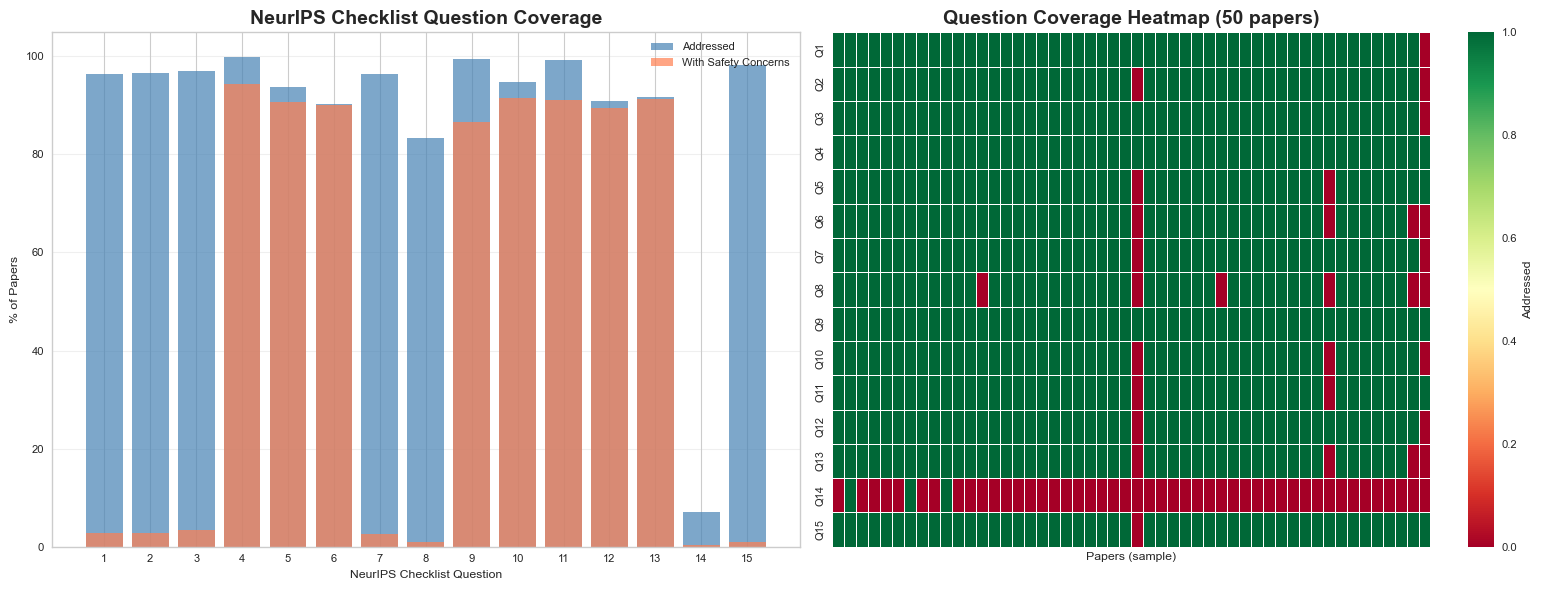

2️⃣  Safety category distribution...
  ✓ 02_safety_categories.png


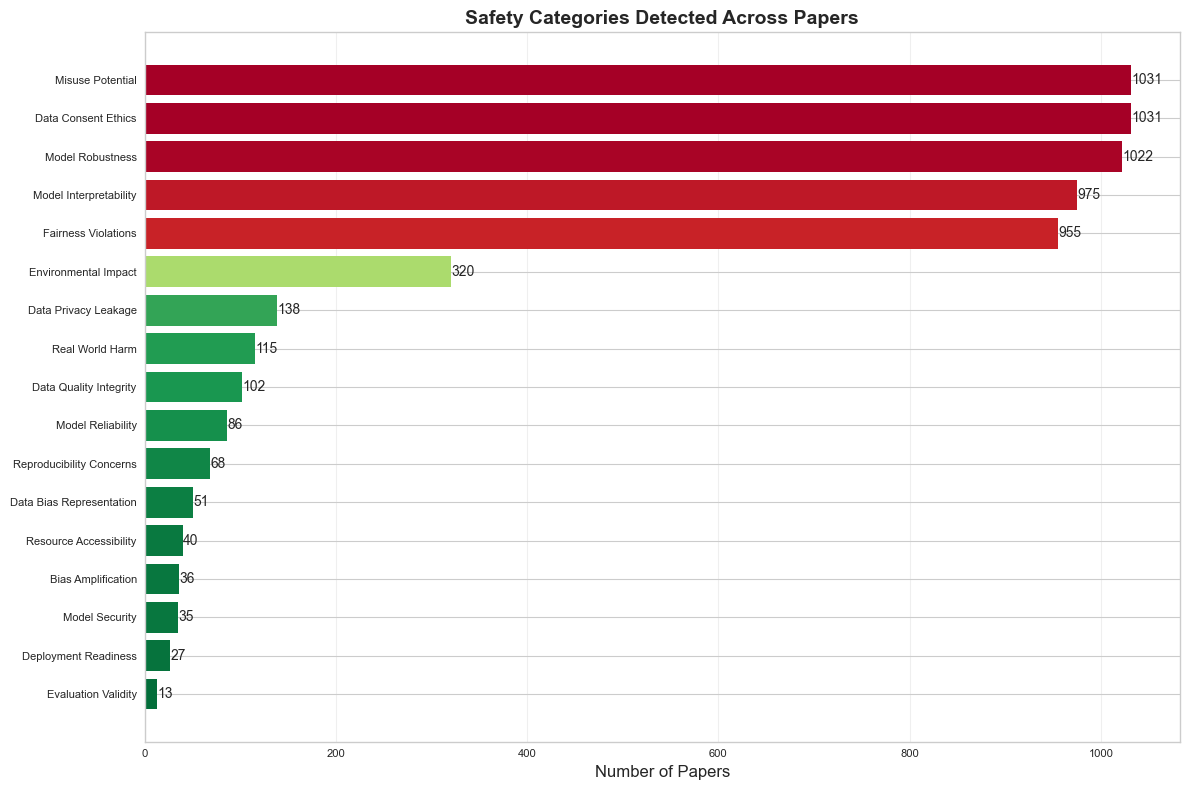

3️⃣  Use case analysis...
  ✓ 03_use_cases.png


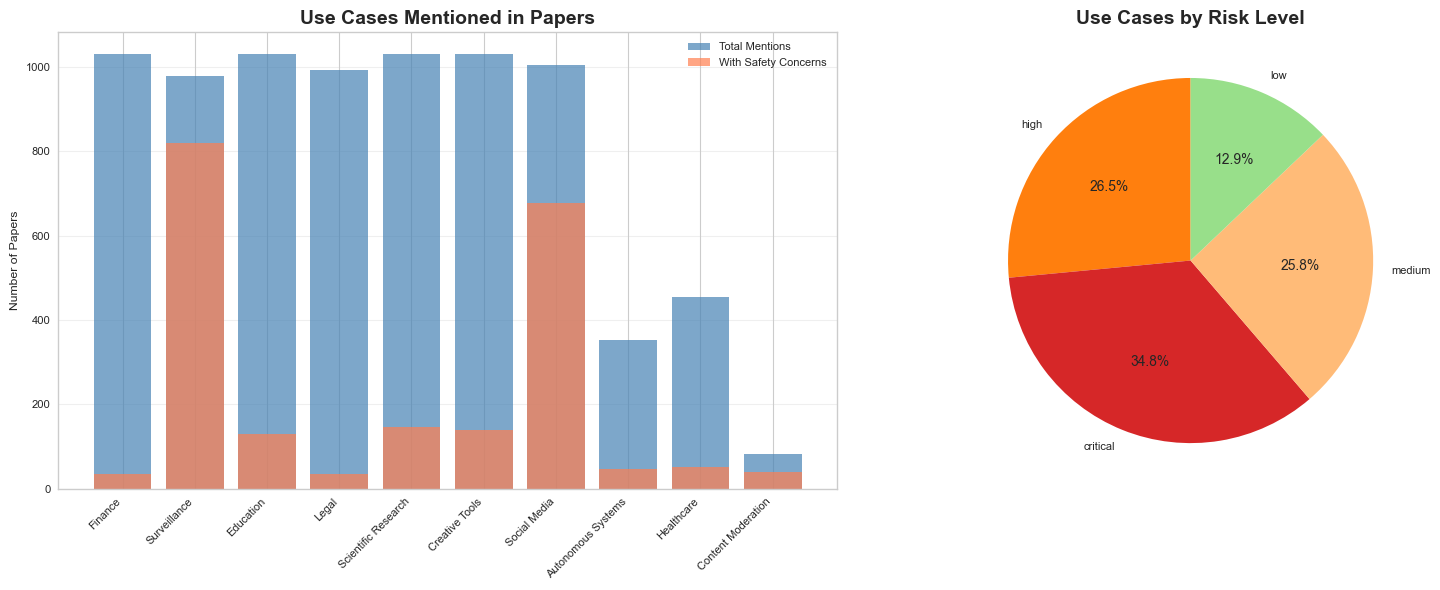

4️⃣  Gap analysis...
  ✓ 04_gap_analysis.png


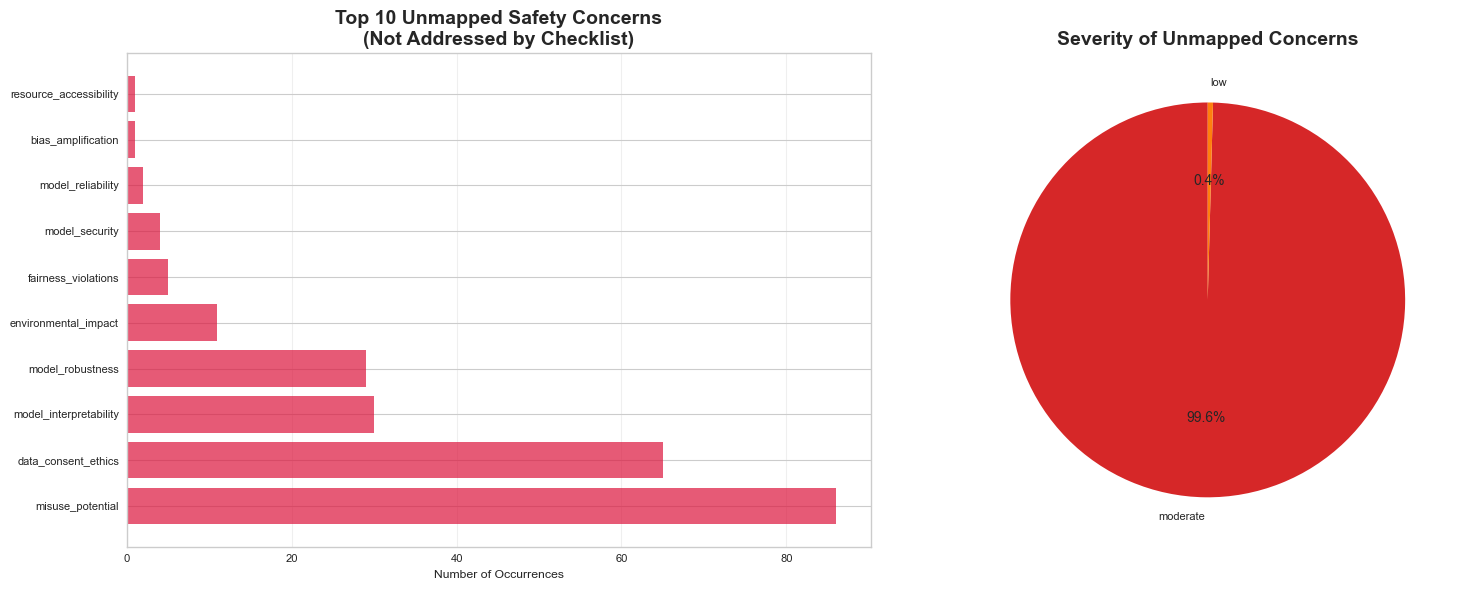

5️⃣  Author safety statements...
  ✓ 05_author_statements.png


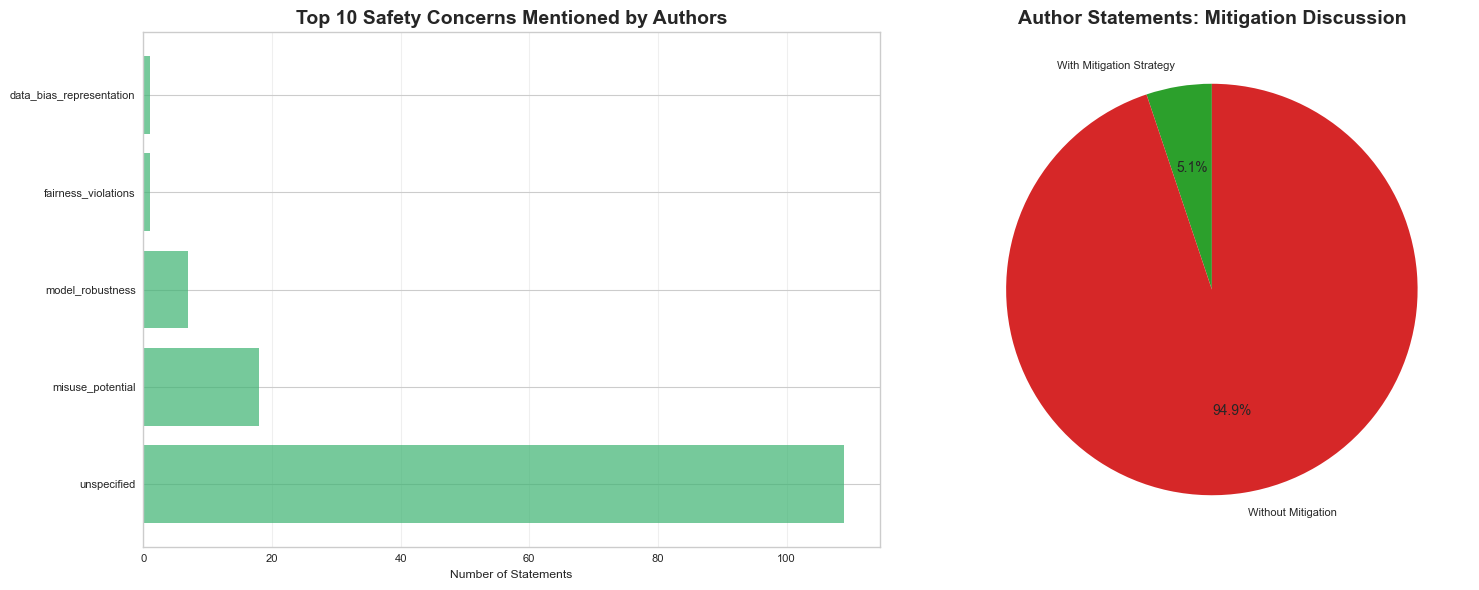

6️⃣  Research area comparison...
  ✓ 06_research_areas.png


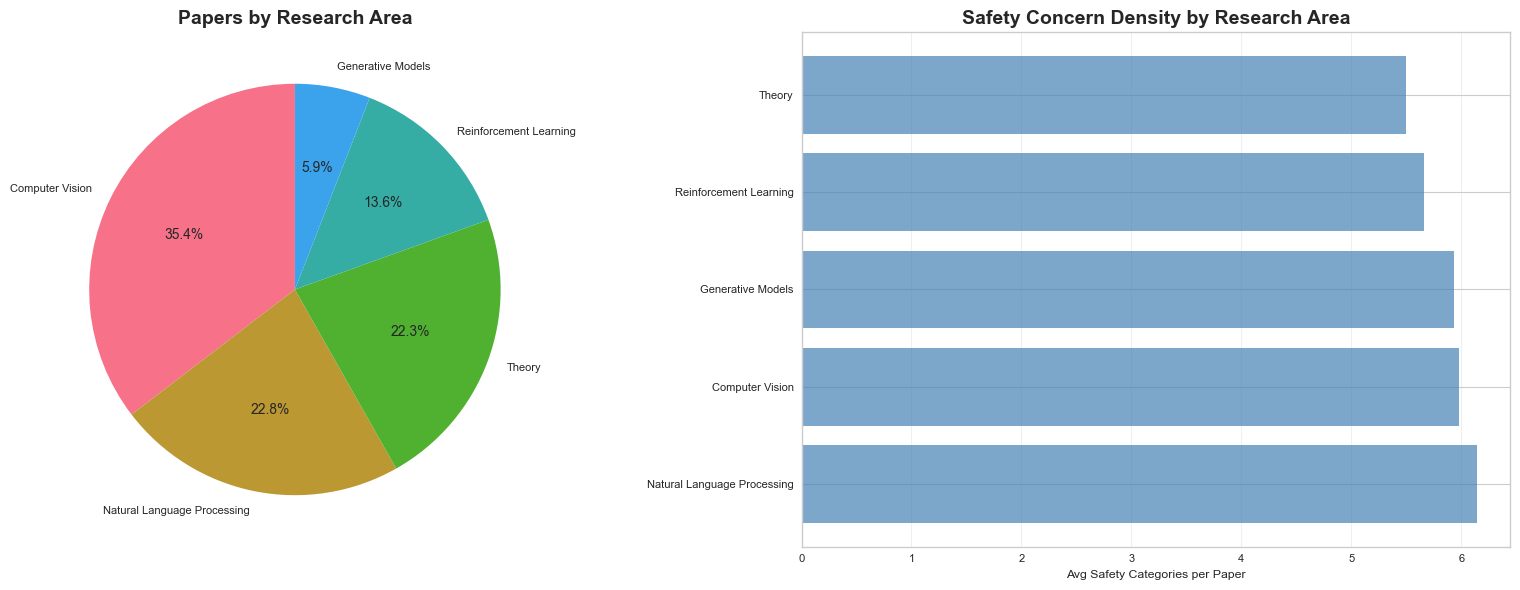

7️⃣  Creating comprehensive dashboard...
  ✓ 00_dashboard.png (comprehensive overview)


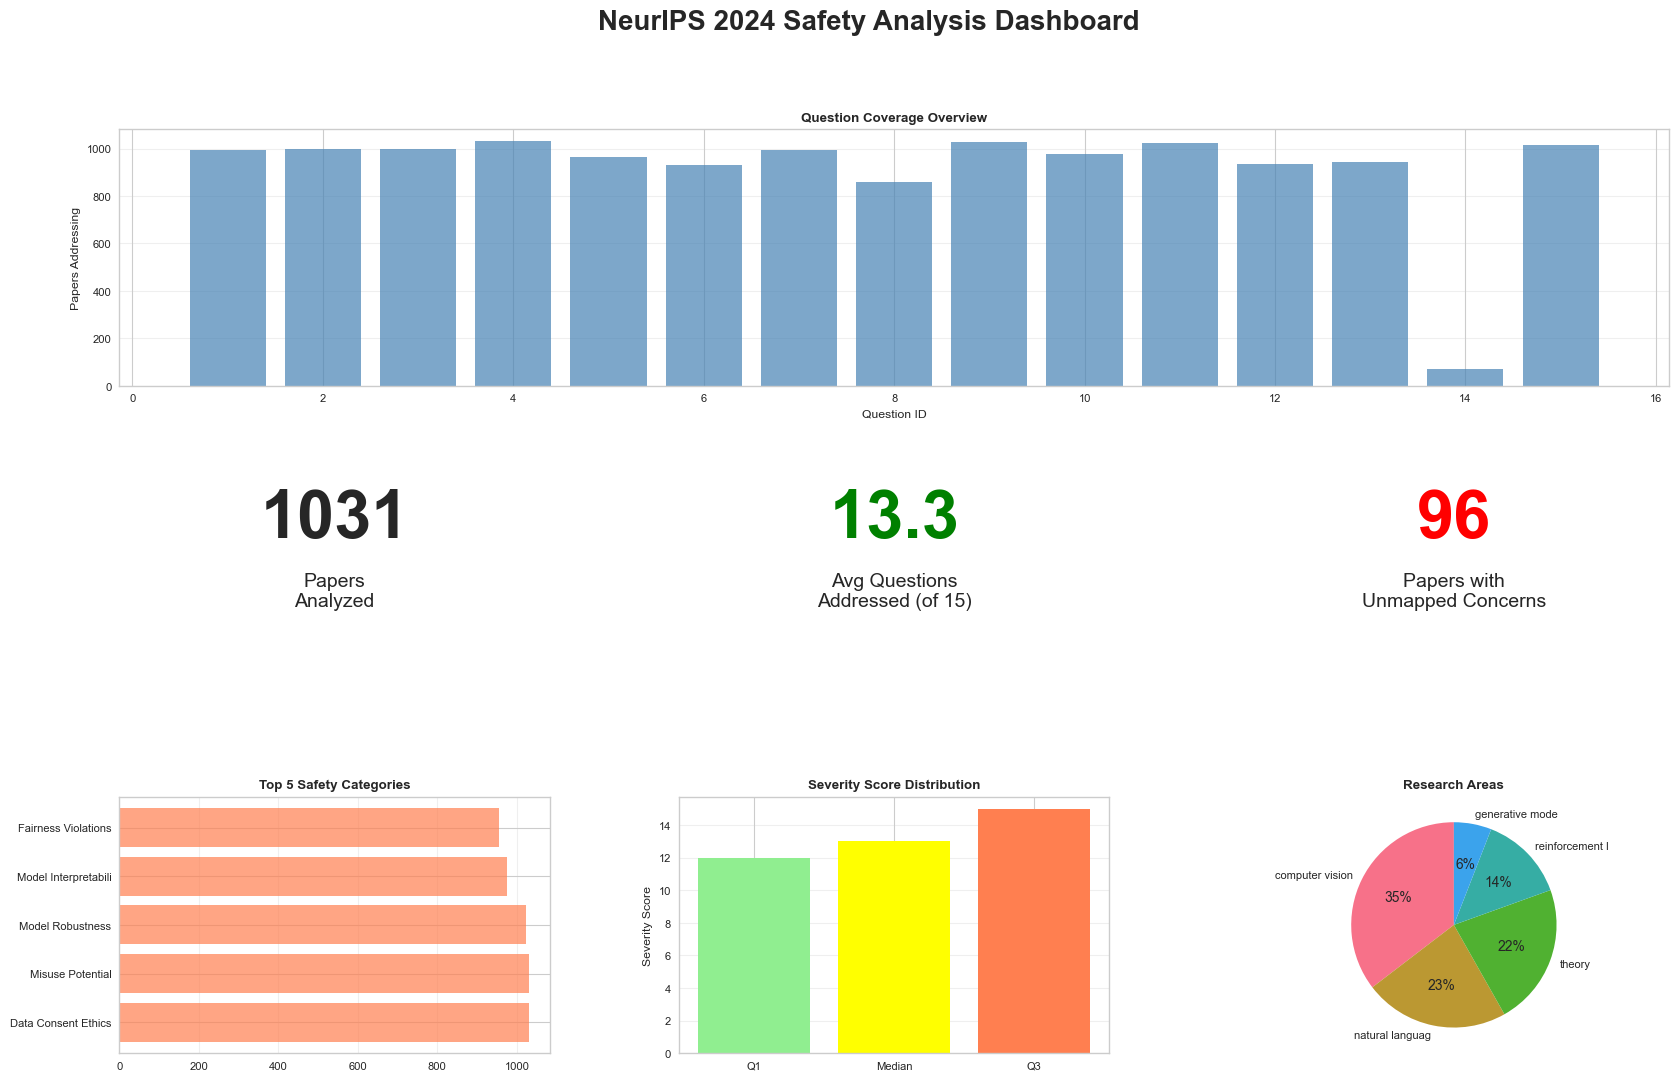


✅ All visualizations saved to outputs\charts


In [10]:
# ============================================================================
# CELL 7: Comprehensive Visualizations
# ============================================================================

# Enable inline plotting for Jupyter
%matplotlib inline

def create_all_visualizations(df: pd.DataFrame, analyses: List[PaperAnalysis], chart_dir: str):
    """
    Generate all required visualizations for the project.
    """
    print(f"\n{'='*70}")
    print("📊 GENERATING VISUALIZATIONS")
    print(f"{'='*70}\n")
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
    
    from IPython.display import display, HTML
    
    # ========================================
    # 1. CHECKLIST QUESTION COVERAGE
    # ========================================
    print("1️⃣  Checklist question coverage...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Coverage rates
    q_columns = [c for c in df.columns if c.startswith('q') and c.endswith('_addressed')]
    coverage_rates = []
    concern_rates = []
    
    for q_id in range(1, 16):
        addr_col = f'q{q_id}_addressed'
        concern_col = f'q{q_id}_has_concern'
        coverage_rates.append(df[addr_col].sum() / len(df) * 100)
        concern_rates.append(df[concern_col].sum() / len(df) * 100)
    
    x = range(1, 16)
    ax1.bar(x, coverage_rates, alpha=0.7, label='Addressed', color='steelblue')
    ax1.bar(x, concern_rates, alpha=0.7, label='With Safety Concerns', color='coral')
    ax1.set_xlabel('NeurIPS Checklist Question')
    ax1.set_ylabel('% of Papers')
    ax1.set_title('NeurIPS Checklist Question Coverage', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.set_xticks(x)
    ax1.grid(axis='y', alpha=0.3)
    
    # Heatmap: Papers × Questions
    q_data = df[[f'q{i}_addressed' for i in range(1, 16)]].astype(int)
    # Sample if too many papers
    if len(q_data) > 50:
        q_data_sample = q_data.sample(50, random_state=42)
    else:
        q_data_sample = q_data
    
    sns.heatmap(q_data_sample.T, cmap='RdYlGn', cbar_kws={'label': 'Addressed'},
                xticklabels=False, yticklabels=[f'Q{i}' for i in range(1, 16)],
                ax=ax2, linewidths=0.5)
    ax2.set_title(f'Question Coverage Heatmap ({len(q_data_sample)} papers)', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Papers (sample)' if len(q_data) > 50 else 'Papers')
    
    plt.tight_layout()
    plt.savefig(os.path.join(chart_dir, '01_checklist_coverage.png'), dpi=300, bbox_inches='tight')
    print("  ✓ 01_checklist_coverage.png")
    plt.show()  # Display in notebook
    plt.close()
    
    # ========================================
    # 2. SAFETY CATEGORY DISTRIBUTION
    # ========================================
    print("2️⃣  Safety category distribution...")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    cat_columns = [c for c in df.columns if c.startswith('cat_')]
    cat_counts = df[cat_columns].sum().sort_values(ascending=True)
    
    # Clean names
    cat_names = [c.replace('cat_', '').replace('_', ' ').title() for c in cat_counts.index]
    
    colors = plt.cm.RdYlGn_r(cat_counts.values / cat_counts.max())
    ax.barh(cat_names, cat_counts.values, color=colors)
    ax.set_xlabel('Number of Papers', fontsize=12)
    ax.set_title('Safety Categories Detected Across Papers', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(cat_counts.values):
        ax.text(v + 0.5, i, str(int(v)), va='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(chart_dir, '02_safety_categories.png'), dpi=300, bbox_inches='tight')
    print("  ✓ 02_safety_categories.png")
    plt.show()  # Display in notebook
    plt.close()
    
    # ========================================
    # 3. USE CASE ANALYSIS (Professor requirement)
    # ========================================
    print("3️⃣  Use case analysis...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Count use cases
    use_case_counts = Counter()
    use_case_with_concerns = Counter()
    
    for analysis in analyses:
        for uc in analysis.use_cases:
            use_case_counts[uc['domain']] += 1
            if uc['has_safety_concern']:
                use_case_with_concerns[uc['domain']] += 1
    
    if use_case_counts:
        domains = list(use_case_counts.keys())
        counts = [use_case_counts[d] for d in domains]
        concern_counts = [use_case_with_concerns[d] for d in domains]
        
        # Bar chart
        x_pos = np.arange(len(domains))
        ax1.bar(x_pos, counts, alpha=0.7, label='Total Mentions', color='steelblue')
        ax1.bar(x_pos, concern_counts, alpha=0.7, label='With Safety Concerns', color='coral')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([d.replace('_', ' ').title() for d in domains], rotation=45, ha='right')
        ax1.set_ylabel('Number of Papers')
        ax1.set_title('Use Cases Mentioned in Papers', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)
        
        # Risk level pie chart
        risk_levels = Counter()
        for domain in domains:
            risk_level = USE_CASE_DOMAINS[domain]['risk_level']
            risk_levels[risk_level] += use_case_counts[domain]
        
        colors_pie = {'critical': '#d62728', 'high': '#ff7f0e', 'medium': '#ffbb78', 'low': '#98df8a'}
        ax2.pie(risk_levels.values(), labels=risk_levels.keys(), autopct='%1.1f%%',
                colors=[colors_pie.get(k, 'gray') for k in risk_levels.keys()],
                startangle=90)
        ax2.set_title('Use Cases by Risk Level', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(chart_dir, '03_use_cases.png'), dpi=300, bbox_inches='tight')
    print("  ✓ 03_use_cases.png")
    plt.show()  # Display in notebook
    plt.close()
    
    # ========================================
    # 4. GAP ANALYSIS VISUALIZATION (Level 2)
    # ========================================
    print("4️⃣  Gap analysis...")
    
    if df['has_unmapped_concerns'].sum() > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Gap frequency by category
        all_gaps = []
        for analysis in analyses:
            for concern in analysis.unmapped_concerns:
                all_gaps.append(concern)
        
        if all_gaps:
            gap_types = Counter([g['concern_type'] for g in all_gaps])
            gap_types_sorted = dict(sorted(gap_types.items(), key=lambda x: x[1], reverse=True)[:10])
            
            ax1.barh(list(gap_types_sorted.keys()), list(gap_types_sorted.values()), color='crimson', alpha=0.7)
            ax1.set_xlabel('Number of Occurrences')
            ax1.set_title('Top 10 Unmapped Safety Concerns\n(Not Addressed by Checklist)', 
                         fontsize=14, fontweight='bold')
            ax1.grid(axis='x', alpha=0.3)
            
            # Severity distribution of gaps
            gap_severity = Counter([g['severity'] for g in all_gaps])
            ax2.pie(gap_severity.values(), labels=gap_severity.keys(), autopct='%1.1f%%',
                   colors=['#d62728', '#ff7f0e', '#98df8a'], startangle=90)
            ax2.set_title('Severity of Unmapped Concerns', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(os.path.join(chart_dir, '04_gap_analysis.png'), dpi=300, bbox_inches='tight')
        print("  ✓ 04_gap_analysis.png")
        plt.show()  # Display in notebook
        plt.close()
    else:
        print("  ℹ️  No gaps to visualize")
    
    # ========================================
    # 5. AUTHOR STATEMENTS ANALYSIS
    # ========================================
    print("5️⃣  Author safety statements...")
    
    all_statements = []
    for analysis in analyses:
        all_statements.extend(analysis.author_safety_statements)
    
    if all_statements:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # By concern type
        concern_types = Counter([s['concern_type'] for s in all_statements])
        top_concerns = dict(sorted(concern_types.items(), key=lambda x: x[1], reverse=True)[:10])
        
        ax1.barh(list(top_concerns.keys()), list(top_concerns.values()), 
                color='mediumseagreen', alpha=0.7)
        ax1.set_xlabel('Number of Statements')
        ax1.set_title('Top 10 Safety Concerns Mentioned by Authors', fontsize=14, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)
        
        # Mitigation mentioned?
        has_mitigation = sum(1 for s in all_statements if s['has_mitigation'])
        no_mitigation = len(all_statements) - has_mitigation
        
        ax2.pie([has_mitigation, no_mitigation], 
               labels=['With Mitigation Strategy', 'Without Mitigation'],
               autopct='%1.1f%%', colors=['#2ca02c', '#d62728'], startangle=90)
        ax2.set_title('Author Statements: Mitigation Discussion', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(os.path.join(chart_dir, '05_author_statements.png'), dpi=300, bbox_inches='tight')
        print("  ✓ 05_author_statements.png")
        plt.show()  # Display in notebook
        plt.close()
    
    # ========================================
    # 6. RESEARCH AREA COMPARISON
    # ========================================
    print("6️⃣  Research area comparison...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Distribution
    area_counts = df['research_area'].value_counts()
    ax1.pie(area_counts.values, labels=[a.replace('_', ' ').title() for a in area_counts.index],
           autopct='%1.1f%%', startangle=90)
    ax1.set_title('Papers by Research Area', fontsize=14, fontweight='bold')
    
    # Safety concerns by area
    area_safety = df.groupby('research_area')['num_safety_categories'].mean().sort_values(ascending=False)
    ax2.barh([a.replace('_', ' ').title() for a in area_safety.index], area_safety.values,
            color='steelblue', alpha=0.7)
    ax2.set_xlabel('Avg Safety Categories per Paper')
    ax2.set_title('Safety Concern Density by Research Area', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(chart_dir, '06_research_areas.png'), dpi=300, bbox_inches='tight')
    print("  ✓ 06_research_areas.png")
    plt.show()  # Display in notebook
    plt.close()
    
    # ========================================
    # 7. COMPREHENSIVE DASHBOARD
    # ========================================
    print("7️⃣  Creating comprehensive dashboard...")
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Question coverage
    ax1 = fig.add_subplot(gs[0, :])
    coverage_data = [df[f'q{i}_addressed'].sum() for i in range(1, 16)]
    ax1.bar(range(1, 16), coverage_data, color='steelblue', alpha=0.7)
    ax1.set_xlabel('Question ID')
    ax1.set_ylabel('Papers Addressing')
    ax1.set_title('Question Coverage Overview', fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Category distribution
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.text(0.5, 0.9, f"{len(analyses)}", ha='center', va='top', fontsize=48, fontweight='bold')
    ax2.text(0.5, 0.5, "Papers\nAnalyzed", ha='center', va='center', fontsize=14)
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.text(0.5, 0.9, f"{df['num_questions_addressed'].mean():.1f}", 
            ha='center', va='top', fontsize=48, fontweight='bold', color='green')
    ax3.text(0.5, 0.5, "Avg Questions\nAddressed (of 15)", ha='center', va='center', fontsize=14)
    ax3.axis('off')
    
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.text(0.5, 0.9, f"{sum(df['has_unmapped_concerns'])}", 
            ha='center', va='top', fontsize=48, fontweight='bold', color='red')
    ax4.text(0.5, 0.5, "Papers with\nUnmapped Concerns", ha='center', va='center', fontsize=14)
    ax4.axis('off')
    
    # Bottom row
    ax5 = fig.add_subplot(gs[2, 0])
    top_cats = df[[c for c in df.columns if c.startswith('cat_')]].sum().sort_values(ascending=False).head(5)
    ax5.barh([c.replace('cat_', '').replace('_', ' ').title()[:20] for c in top_cats.index], 
            top_cats.values, color='coral', alpha=0.7)
    ax5.set_title('Top 5 Safety Categories', fontweight='bold')
    ax5.grid(axis='x', alpha=0.3)
    
    ax6 = fig.add_subplot(gs[2, 1])
    severity_dist = [
        df['severity_score'].quantile(0.25),
        df['severity_score'].median(),
        df['severity_score'].quantile(0.75)
    ]
    ax6.bar(['Q1', 'Median', 'Q3'], severity_dist, color=['lightgreen', 'yellow', 'coral'])
    ax6.set_ylabel('Severity Score')
    ax6.set_title('Severity Score Distribution', fontweight='bold')
    ax6.grid(axis='y', alpha=0.3)
    
    ax7 = fig.add_subplot(gs[2, 2])
    area_counts_top = df['research_area'].value_counts().head(5)
    ax7.pie(area_counts_top.values, labels=[a.replace('_', ' ')[:15] for a in area_counts_top.index],
           autopct='%1.0f%%', startangle=90)
    ax7.set_title('Research Areas', fontweight='bold')
    
    fig.suptitle('NeurIPS 2024 Safety Analysis Dashboard', fontsize=20, fontweight='bold', y=0.98)
    
    plt.savefig(os.path.join(chart_dir, '00_dashboard.png'), dpi=300, bbox_inches='tight')
    print("  ✓ 00_dashboard.png (comprehensive overview)")
    plt.show()  # Display in notebook
    plt.close()
    
    print(f"\n✅ All visualizations saved to {chart_dir}")
    
    # Display summary message
    display(HTML(f"""
    <div style="background-color: #e8f5e9; padding: 15px; border-radius: 5px; border-left: 5px solid #4caf50;">
        <h3 style="color: #2e7d32; margin-top: 0;">✅ Visualization Complete!</h3>
        <p><strong>7 charts generated and displayed above</strong></p>
        <p>📁 All charts saved to: <code>{chart_dir}</code></p>
        <ul>
            <li>00_dashboard.png - Comprehensive overview</li>
            <li>01_checklist_coverage.png - Question analysis</li>
            <li>02_safety_categories.png - Category distribution</li>
            <li>03_use_cases.png - Application domains</li>
            <li>04_gap_analysis.png - Unmapped concerns</li>
            <li>05_author_statements.png - Author-driven taxonomy</li>
            <li>06_research_areas.png - Research area comparison</li>
        </ul>
        <p><em>Proceed to Cell 8 to view detailed results summary</em></p>
    </div>
    """))


# ============================================================================
# GENERATE ALL VISUALIZATIONS
# ============================================================================

if 'df' in locals() and not df.empty:
    create_all_visualizations(df, analyses, CHART_DIR)
else:
    print("  Run Cell 6 first to generate analysis data!")

In [11]:
# ============================================================================
# CELL 8: Interactive Results Explorer
# ============================================================================

from IPython.display import display, HTML, Markdown
import ipywidgets as widgets

def create_interactive_dashboard(df: pd.DataFrame, analyses: List[PaperAnalysis]):
    """
    Create interactive dashboard with widgets for exploring results.
    """
    
    # ========================================
    # HEADER
    # ========================================
    display(HTML("""
    <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                padding: 30px; border-radius: 10px; color: white; text-align: center;">
        <h1 style="margin: 0; font-size: 2.5em;">📊 NeurIPS 2024 Safety Analysis</h1>
        <p style="margin: 10px 0 0 0; font-size: 1.2em;">Interactive Results Dashboard</p>
    </div>
    """))
    
    # ========================================
    # KEY METRICS CARDS
    # ========================================
    display(HTML(f"""
    <div style="display: grid; grid-template-columns: repeat(4, 1fr); gap: 15px; margin: 20px 0;">
        <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                    padding: 20px; border-radius: 10px; color: white; text-align: center;">
            <div style="font-size: 3em; font-weight: bold;">{len(analyses)}</div>
            <div style="font-size: 1.1em; margin-top: 5px;">Papers Analyzed</div>
        </div>
        <div style="background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); 
                    padding: 20px; border-radius: 10px; color: white; text-align: center;">
            <div style="font-size: 3em; font-weight: bold;">{df['num_questions_addressed'].mean():.1f}/15</div>
            <div style="font-size: 1.1em; margin-top: 5px;">Avg Questions</div>
        </div>
        <div style="background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%); 
                    padding: 20px; border-radius: 10px; color: white; text-align: center;">
            <div style="font-size: 3em; font-weight: bold;">{sum(df['has_unmapped_concerns'])}</div>
            <div style="font-size: 1.1em; margin-top: 5px;">Papers with Gaps</div>
        </div>
        <div style="background: linear-gradient(135deg, #43e97b 0%, #38f9d7 100%); 
                    padding: 20px; border-radius: 10px; color: white; text-align: center;">
            <div style="font-size: 3em; font-weight: bold;">{df['num_author_statements'].sum()}</div>
            <div style="font-size: 1.1em; margin-top: 5px;">Author Statements</div>
        </div>
    </div>
    """))
    
    # ========================================
    # INTERACTIVE TABS
    # ========================================
    
    # Create tabs
    tab_contents = []
    tab_titles = [
        "📋 Checklist Analysis",
        "🔒 Safety Categories", 
        "🎯 Use Cases",
        "🔍 Gap Analysis",
        "✍️ Author Statements",
        "🔬 Research Areas",
        "📊 Paper Explorer"
    ]
    
    # TAB 1: Checklist Analysis
    checklist_output = widgets.Output()
    with checklist_output:
        display(HTML("<h2>NeurIPS Checklist Question Coverage</h2>"))
        
        # Create question selector
        question_dropdown = widgets.Dropdown(
            options=[(f"Q{i}: {NEURIPS_QUESTIONS[i]['text'][:60]}...", i) for i in range(1, 16)],
            description='Question:',
            style={'description_width': '100px'},
            layout=widgets.Layout(width='80%')
        )
        
        question_output = widgets.Output()
        
        def show_question_details(change):
            with question_output:
                question_output.clear_output()
                q_id = change['new']
                q_info = NEURIPS_QUESTIONS[q_id]
                
                addressed = df[f'q{q_id}_addressed'].sum()
                concerns = df[f'q{q_id}_has_concern'].sum()
                
                display(HTML(f"""
                <div style="border: 2px solid #667eea; padding: 20px; border-radius: 10px; margin: 10px 0;">
                    <h3 style="color: #667eea;">Question {q_id}</h3>
                    <p><strong>Category:</strong> {q_info['category']}</p>
                    <p><strong>Full Text:</strong> {q_info['text']}</p>
                    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin-top: 15px;">
                        <div style="background: #e8f5e9; padding: 15px; border-radius: 5px;">
                            <div style="font-size: 2em; font-weight: bold; color: #2e7d32;">{addressed}/{len(df)}</div>
                            <div>Papers Addressed ({addressed/len(df)*100:.1f}%)</div>
                        </div>
                        <div style="background: #fff3e0; padding: 15px; border-radius: 5px;">
                            <div style="font-size: 2em; font-weight: bold; color: #e65100;">{concerns}/{len(df)}</div>
                            <div>Raised Safety Concerns ({concerns/len(df)*100:.1f}%)</div>
                        </div>
                    </div>
                </div>
                """))
                
                # Show example papers
                example_papers = df[df[f'q{q_id}_addressed'] == True].head(3)
                if len(example_papers) > 0:
                    display(HTML("<h4>Example Papers Addressing This Question:</h4>"))
                    for idx, row in example_papers.iterrows():
                        has_concern_emoji = "⚠️" if row[f'q{q_id}_has_concern'] else "✅"
                        display(HTML(f"""
                        <div style="background: #f5f5f5; padding: 10px; margin: 5px 0; border-radius: 5px;">
                            {has_concern_emoji} <strong>{row['paper_id']}</strong> - {row['title'][:80]}...
                        </div>
                        """))
        
        question_dropdown.observe(show_question_details, names='value')
        display(question_dropdown)
        display(question_output)
        
        # Trigger initial display
        show_question_details({'new': 1})
    
    tab_contents.append(checklist_output)
    
    # TAB 2: Safety Categories
    safety_output = widgets.Output()
    with safety_output:
        display(HTML("<h2>Safety Category Analysis</h2>"))
        
        cat_columns = [c for c in df.columns if c.startswith('cat_')]
        cat_counts = df[cat_columns].sum().sort_values(ascending=False)
        
        # Interactive bar chart
        fig, ax = plt.subplots(figsize=(12, 8))
        colors = plt.cm.RdYlGn_r(cat_counts.values / cat_counts.max())
        bars = ax.barh([c.replace('cat_', '').replace('_', ' ').title() for c in cat_counts.index], 
                       cat_counts.values, color=colors)
        ax.set_xlabel('Number of Papers', fontsize=12)
        ax.set_title('Safety Categories Detected Across Papers', fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (bar, v) in enumerate(zip(bars, cat_counts.values)):
            ax.text(v + 0.5, bar.get_y() + bar.get_height()/2, 
                   f'{int(v)} ({v/len(df)*100:.1f}%)', 
                   va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Category selector for details
        display(HTML("<h3>Explore Categories:</h3>"))
        
        category_dropdown = widgets.Dropdown(
            options=[(c.replace('cat_', '').replace('_', ' ').title(), c) for c in cat_counts.index],
            description='Category:',
            style={'description_width': '100px'},
            layout=widgets.Layout(width='60%')
        )
        
        category_output = widgets.Output()
        
        def show_category_details(change):
            with category_output:
                category_output.clear_output()
                cat_col = change['new']
                cat_name = cat_col.replace('cat_', '')
                
                papers_with_cat = df[df[cat_col] == True]
                count = len(papers_with_cat)
                
                # Get mapped questions
                if cat_name in SAFETY_TAXONOMY:
                    mapped_qs = SAFETY_TAXONOMY[cat_name]['maps_to_questions']
                    severity = SAFETY_TAXONOMY[cat_name]['severity_weight']
                else:
                    mapped_qs = []
                    severity = 1
                
                display(HTML(f"""
                <div style="border: 2px solid #f5576c; padding: 20px; border-radius: 10px; margin: 10px 0;">
                    <h3 style="color: #f5576c;">{cat_name.replace('_', ' ').title()}</h3>
                    <p><strong>Papers Detected:</strong> {count} ({count/len(df)*100:.1f}%)</p>
                    <p><strong>Severity Weight:</strong> {'⭐' * severity}</p>
                    <p><strong>Maps to Questions:</strong> {', '.join([f'Q{q}' for q in mapped_qs])}</p>
                </div>
                """))
                
                # Show top papers
                if count > 0:
                    display(HTML(f"<h4>Top Papers with {cat_name.replace('_', ' ').title()}:</h4>"))
                    for idx, row in papers_with_cat.head(5).iterrows():
                        display(HTML(f"""
                        <div style="background: #f5f5f5; padding: 10px; margin: 5px 0; border-radius: 5px;">
                            📄 <strong>{row['paper_id']}</strong> - {row['title'][:80]}...
                            <br><small>Research Area: {row['research_area']}</small>
                        </div>
                        """))
        
        category_dropdown.observe(show_category_details, names='value')
        display(category_dropdown)
        display(category_output)
        
        # Trigger initial display
        show_category_details({'new': cat_counts.index[0]})
    
    tab_contents.append(safety_output)
    
    # TAB 3: Use Cases
    usecase_output = widgets.Output()
    with usecase_output:
        display(HTML("<h2>Application Domain Analysis</h2>"))
        
        # Aggregate use cases
        use_case_summary = {}
        for analysis in analyses:
            for uc in analysis.use_cases:
                domain = uc['domain']
                if domain not in use_case_summary:
                    use_case_summary[domain] = {
                        'count': 0,
                        'with_concerns': 0,
                        'risk_level': uc['risk_level']
                    }
                use_case_summary[domain]['count'] += 1
                if uc['has_safety_concern']:
                    use_case_summary[domain]['with_concerns'] += 1
        
        if use_case_summary:
            # Create grid of use case cards
            for domain, info in sorted(use_case_summary.items(), key=lambda x: x[1]['count'], reverse=True):
                risk_color = {
                    'critical': '#d32f2f',
                    'high': '#f57c00',
                    'medium': '#fbc02d',
                    'low': '#388e3c'
                }.get(info['risk_level'], '#757575')
                
                concern_pct = info['with_concerns'] / info['count'] * 100 if info['count'] > 0 else 0
                
                display(HTML(f"""
                <div style="border-left: 5px solid {risk_color}; background: #fafafa; 
                            padding: 15px; margin: 10px 0; border-radius: 5px;">
                    <div style="display: flex; justify-content: space-between; align-items: center;">
                        <div>
                            <h3 style="margin: 0; color: {risk_color};">
                                {domain.replace('_', ' ').title()}
                            </h3>
                            <p style="margin: 5px 0;">
                                <strong>Risk Level:</strong> <span style="color: {risk_color};">{info['risk_level'].upper()}</span>
                            </p>
                        </div>
                        <div style="text-align: right;">
                            <div style="font-size: 2em; font-weight: bold;">{info['count']}</div>
                            <div>papers</div>
                        </div>
                    </div>
                    <div style="margin-top: 10px; background: white; padding: 10px; border-radius: 5px;">
                        <div style="font-size: 0.9em;">
                            ⚠️ <strong>{info['with_concerns']}</strong> papers raised safety concerns 
                            ({concern_pct:.1f}%)
                        </div>
                        <div style="background: #e0e0e0; height: 10px; border-radius: 5px; margin-top: 5px;">
                            <div style="background: {risk_color}; height: 100%; width: {concern_pct}%; 
                                        border-radius: 5px;"></div>
                        </div>
                    </div>
                </div>
                """))
        else:
            display(HTML("<p><em>No use cases detected in the analyzed papers.</em></p>"))
    
    tab_contents.append(usecase_output)
    
    # TAB 4: Gap Analysis
    gap_output = widgets.Output()
    with gap_output:
        display(HTML("<h2>Gap Analysis - Unmapped Safety Concerns</h2>"))
        
        all_gaps = []
        for analysis in analyses:
            all_gaps.extend(analysis.unmapped_concerns)
        
        if all_gaps:
            gap_df_temp = pd.DataFrame(all_gaps)
            gap_types = gap_df_temp['concern_type'].value_counts()
            
            display(HTML(f"""
            <div style="background: #fff3e0; border-left: 5px solid #ff9800; 
                        padding: 20px; border-radius: 5px; margin-bottom: 20px;">
                <h3 style="color: #e65100; margin-top: 0;">⚠️ Key Finding</h3>
                <p><strong>{len(all_gaps)}</strong> safety concerns were identified that are 
                <strong>NOT addressed by any NeurIPS checklist question</strong>.</p>
                <p>These concerns appear in <strong>{sum(df['has_unmapped_concerns'])}</strong> 
                papers ({sum(df['has_unmapped_concerns'])/len(df)*100:.1f}% of analyzed papers).</p>
            </div>
            """))
            
            # Top gaps
            display(HTML("<h3>Most Common Unmapped Concerns:</h3>"))
            for i, (concern_type, count) in enumerate(gap_types.head(10).items(), 1):
                severity_dist = gap_df_temp[gap_df_temp['concern_type'] == concern_type]['severity'].value_counts()
                
                display(HTML(f"""
                <div style="background: #ffebee; padding: 15px; margin: 10px 0; 
                            border-radius: 5px; border-left: 4px solid #c62828;">
                    <div style="display: flex; justify-content: space-between;">
                        <div style="flex: 1;">
                            <strong>#{i}. {concern_type.replace('_', ' ').title()}</strong>
                            <div style="font-size: 0.9em; color: #666; margin-top: 5px;">
                                Severity: {' | '.join([f"{sev}: {cnt}" for sev, cnt in severity_dist.items()])}
                            </div>
                        </div>
                        <div style="background: #c62828; color: white; padding: 10px 20px; 
                                    border-radius: 20px; font-weight: bold;">
                            {count}
                        </div>
                    </div>
                </div>
                """))
        else:
            display(HTML("""
            <div style="background: #e8f5e9; border-left: 5px solid #4caf50; 
                        padding: 20px; border-radius: 5px;">
                <h3 style="color: #2e7d32; margin-top: 0;">✅ No Gaps Detected</h3>
                <p>All detected safety concerns map to at least one NeurIPS checklist question.</p>
            </div>
            """))
    
    tab_contents.append(gap_output)
    
    # TAB 5: Author Statements
    author_output = widgets.Output()
    with author_output:
        display(HTML("<h2>Author Safety Statements Analysis</h2>"))
        
        all_statements = []
        for analysis in analyses:
            for stmt in analysis.author_safety_statements:
                # Add paper_id to each statement
                stmt_with_id = stmt.copy()
                stmt_with_id['paper_id'] = analysis.paper_id
                all_statements.append(stmt_with_id)
        
        if all_statements:
            stmt_df_temp = pd.DataFrame(all_statements)
            
            display(HTML(f"""
            <div style="background: #e3f2fd; border-left: 5px solid #2196f3; 
                        padding: 20px; border-radius: 5px; margin-bottom: 20px;">
                <h3 style="color: #1565c0; margin-top: 0;">📝 Author-Driven Insights</h3>
                <p><strong>{len(all_statements)}</strong> explicit safety statements extracted from authors.</p>
                <p>Found in <strong>{len(set(s['paper_id'] for s in all_statements))}</strong> papers.</p>
            </div>
            """))
            
            # Statements by type
            concern_types = stmt_df_temp['concern_type'].value_counts()
            display(HTML("<h3>Safety Concerns Mentioned by Authors:</h3>"))
            
            for concern, count in concern_types.head(8).items():
                examples = stmt_df_temp[stmt_df_temp['concern_type'] == concern]['text'].head(2)
                
                display(HTML(f"""
                <div style="background: #f5f5f5; padding: 15px; margin: 10px 0; border-radius: 5px;">
                    <div style="display: flex; justify-content: space-between; align-items: center; 
                                margin-bottom: 10px;">
                        <strong style="color: #1976d2;">{concern.replace('_', ' ').title()}</strong>
                        <span style="background: #1976d2; color: white; padding: 5px 15px; 
                                     border-radius: 15px;">{count}</span>
                    </div>
                    <div style="background: white; padding: 10px; border-radius: 5px; 
                                border-left: 3px solid #1976d2;">
                        <p style="margin: 0; font-size: 0.9em; font-style: italic;">
                            "{examples.iloc[0][:150]}..."
                        </p>
                    </div>
                </div>
                """))
        else:
            display(HTML("<p><em>No author safety statements extracted.</em></p>"))
    
    tab_contents.append(author_output)
    
    # TAB 6: Research Areas
    area_output = widgets.Output()
    with area_output:
        display(HTML("<h2>Research Area Breakdown</h2>"))
        
        area_stats = df.groupby('research_area').agg({
            'paper_id': 'count',
            'num_safety_categories': 'mean',
            'num_questions_addressed': 'mean',
            'has_unmapped_concerns': 'sum'
        }).round(2)
        area_stats.columns = ['Papers', 'Avg Safety Categories', 'Avg Questions', 'Papers with Gaps']
        
        # Display as styled table
        display(HTML(area_stats.to_html(classes='dataframe', 
                                        escape=False,
                                        border=0)))
    
    tab_contents.append(area_output)
    
    # TAB 7: Paper Explorer
    explorer_output = widgets.Output()
    with explorer_output:
        display(HTML("<h2>Individual Paper Explorer</h2>"))
        
        # Paper selector
        paper_dropdown = widgets.Dropdown(
            options=[(f"{row['paper_id']}: {row['title'][:60]}...", row['paper_id']) 
                    for _, row in df.iterrows()],
            description='Paper:',
            style={'description_width': '70px'},
            layout=widgets.Layout(width='90%')
        )
        
        paper_output = widgets.Output()
        
        def show_paper_details(change):
            with paper_output:
                paper_output.clear_output()
                paper_id = change['new']
                paper_row = df[df['paper_id'] == paper_id].iloc[0]
                paper_analysis = next((a for a in analyses if a.paper_id == paper_id), None)
                
                if paper_analysis:
                    display(HTML(f"""
                    <div style="border: 2px solid #667eea; padding: 20px; border-radius: 10px;">
                        <h3 style="color: #667eea;">{paper_analysis.title}</h3>
                        <p><strong>Paper ID:</strong> {paper_id}</p>
                        <p><strong>Research Area:</strong> {paper_row['research_area'].replace('_', ' ').title()}</p>
                        
                        <div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 15px; margin: 20px 0;">
                            <div style="background: #e8f5e9; padding: 15px; border-radius: 5px; text-align: center;">
                                <div style="font-size: 2em; font-weight: bold; color: #2e7d32;">
                                    {paper_row['num_questions_addressed']}/15
                                </div>
                                <div>Questions Addressed</div>
                            </div>
                            <div style="background: #fff3e0; padding: 15px; border-radius: 5px; text-align: center;">
                                <div style="font-size: 2em; font-weight: bold; color: #e65100;">
                                    {paper_row['num_safety_categories']}
                                </div>
                                <div>Safety Categories</div>
                            </div>
                            <div style="background: #fce4ec; padding: 15px; border-radius: 5px; text-align: center;">
                                <div style="font-size: 2em; font-weight: bold; color: #c2185b;">
                                    {len(paper_analysis.use_cases)}
                                </div>
                                <div>Use Cases</div>
                            </div>
                        </div>
                        
                        <h4>Questions Addressed:</h4>
                        <div style="display: flex; flex-wrap: wrap; gap: 5px;">
                            {"".join([f'<span style="background: #4caf50; color: white; padding: 5px 10px; border-radius: 5px; margin: 2px;">Q{q}</span>' for q in paper_analysis.questions_addressed])}
                        </div>
                        
                        <h4 style="margin-top: 15px;">Safety Categories Detected:</h4>
                        <div style="display: flex; flex-wrap: wrap; gap: 5px;">
                            {"".join([f'<span style="background: #ff9800; color: white; padding: 5px 10px; border-radius: 5px; margin: 2px;">{cat.replace("_", " ").title()}</span>' 
                                     for cat, info in paper_analysis.safety_categories.items() if info['detected']])}
                        </div>
                        
                        {"<h4 style='margin-top: 15px;'>⚠️ Has Unmapped Concerns</h4>" if paper_row['has_unmapped_concerns'] else ""}
                    </div>
                    """))
        
        paper_dropdown.observe(show_paper_details, names='value')
        display(paper_dropdown)
        display(paper_output)
        
        # Trigger initial display
        if len(df) > 0:
            show_paper_details({'new': df.iloc[0]['paper_id']})
    
    tab_contents.append(explorer_output)
    
    # Create tab widget
    tabs = widgets.Tab(children=tab_contents)
    for i, title in enumerate(tab_titles):
        tabs.set_title(i, title)
    
    display(tabs)
    
    # ========================================
    # FOOTER WITH ACTION BUTTONS
    # ========================================
    display(HTML(f"""
    <div style="background: #f5f5f5; padding: 20px; border-radius: 10px; margin-top: 30px; text-align: center;">
        <h3>📁 Output Files Available</h3>
        <p>All results have been saved to: <code>{OUT_DIR}</code></p>
        <p>All visualizations saved to: <code>{CHART_DIR}</code></p>
        <p><small>Use the tabs above to explore different aspects of the analysis</small></p>
    </div>
    """))


# ============================================================================
# DISPLAY INTERACTIVE DASHBOARD
# ============================================================================

if 'df' in locals() and 'analyses' in locals():
    create_interactive_dashboard(df, analyses)
else:
    print("⚠️  Run Cell 6 first to generate results!")